In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import glob
import os
import time
import pickle
import datetime
import networkx as nx

import sys
sys.path.append('/home/ngrav/project/')
from wearables.scripts import utils as wearutils
from wearables.scripts import data as weardata
from wearables.scripts import train as weartrain
from wearables.scripts import eval_ as weareval
from wearables.scripts import model as wearmodels
from wearables.scripts import DTW as weardtw
from wearables.scripts import error_analysis as wearerr

import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from scipy.stats import kruskal
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.regression.compose._ensemble import ComposableTimeSeriesForestRegressor
from sktime.classification.compose import ComposableTimeSeriesForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=1
plt.rcParams['savefig.dpi'] = 600
sns.set_style("ticks")

def loadpkl(fp):
    with open(fp, 'rb') as f:
        return pickle.load(f)

In [2]:
# load data

pfp = '/home/ngrav/project/wearables/results/'
mfp = '/home/ngrav/scratch/wearables_model_zoo'

# filepaths to bst or pre-processed md with calculated metrics 
pp_md_fp = os.path.join(pfp, 'md_220912.csv')
bst_trainer = os.path.join(mfp, 'trainer_itv71_InceptionTime_GA4.pkl')
bst_modelpkl = os.path.join(mfp, '281-itv71_InceptionTime_GA4.pkl')

# load up to date md
md = pd.read_csv(pp_md_fp, index_col=0)
trainer = loadpkl(bst_trainer)


In [3]:
if False:
    # don't run after save
    
    # call eval to get output, modify for return_hidden = True option
    evaluation = weareval.eval_trained(trainer, split='train',
                                       modelpkl=bst_modelpkl,
                                       two_outputs=True)

    evaluation.results['split'] = 'train'
    evaluation.results.index = evaluation.id
    evaluation.results.to_csv(os.path.join(pfp, 'md_results_train_220912.csv'))
    pd.DataFrame(evaluation.out2.numpy(), index=evaluation.id).to_csv(os.path.join(pfp, 'embeds_train_220912.csv'))

    # val
    evaluation_val = weareval.eval_trained(
        trainer, split='val',
        modelpkl=bst_modelpkl,
        two_outputs=True)
    evaluation_val.results['split'] = 'val'
    evaluation_val.results.index = evaluation_val.id
    evaluation_val.results.to_csv(os.path.join(pfp, 'md_results_val_220912.csv'))
    pd.DataFrame(evaluation_val.out2.numpy(), index=evaluation_val.id).to_csv(os.path.join(pfp, 'embeds_val_220912.csv'))

    # test 
    evaluation_test = weareval.eval_trained(
        trainer, split='test',
        modelpkl=bst_modelpkl,
        two_outputs=True)
    evaluation_test.results['split'] = 'test'
    evaluation_test.results.index = evaluation_test.id
    evaluation_test.results.to_csv(os.path.join(pfp, 'md_results_test_220912.csv'))
    pd.DataFrame(evaluation_test.out2.numpy(), index=evaluation_test.id).to_csv(os.path.join(pfp, 'embeds_test_220912.csv'))

    # merge all
    md_res = evaluation.results.append(evaluation_val.results.append(evaluation_test.results))
    md_res
    md_res.to_csv(os.path.join(pfp, 'md_res_220912.csv'))

In [4]:
# add error
threshold = 10 # for error groups
md['error'] = md['yhat'] - md['y']

# assign error groups
md['Error group'] = 'lt{}wks'.format(threshold)
md.loc[(md['error'] >= threshold), 'Error group'] = 'Higher-than-actual'
md.loc[(md['error'] <= -threshold), 'Error group'] = 'Lower-than-actual'


In [5]:
# load raw metadata and check counts
raw_md = '/home/ngrav/data/wearables/raw/MOD_Data_2021.csv'
assert os.path.exists(raw_md)
raw_md = pd.read_csv(raw_md, low_memory=False)

# filter down to only those in the cohort
raw_md = raw_md.loc[raw_md['record_id'].isin(md['record_id'])]

In [6]:
# create map of record_id to any_induction
for cc in [c for c in raw_md.columns if 'indu' in c]:
    print('\n{}'.format(cc))
    print(raw_md[cc].value_counts(dropna=False))


induct___1
0    1078
1       5
Name: induct___1, dtype: int64

induct___2
0    1076
1       7
Name: induct___2, dtype: int64

induct___3
0    1077
1       6
Name: induct___3, dtype: int64

induct___4
0    1036
1      47
Name: induct___4, dtype: int64

induct___5
0    1051
1      32
Name: induct___5, dtype: int64

induct___6
0    876
1    207
Name: induct___6, dtype: int64

induct___7
0    1047
1      36
Name: induct___7, dtype: int64

induct___8
0    1070
1      13
Name: induct___8, dtype: int64

induct___9
0    1029
1      54
Name: induct___9, dtype: int64

induct___10
0    1043
1      40
Name: induct___10, dtype: int64

induct___11
0    1081
1       2
Name: induct___11, dtype: int64

induct___12
0    1079
1       4
Name: induct___12, dtype: int64

induct___13
0    1077
1       6
Name: induct___13, dtype: int64

induct___14
0    1019
1      64
Name: induct___14, dtype: int64

induct_other_text
NaN                                                    1019
gHTN                           

In [7]:
flag_cols = [c for c in raw_md.columns if 'indu' in c][:-1]
txt_col = 'induct_other_text'
flag_cols

['induct___1',
 'induct___2',
 'induct___3',
 'induct___4',
 'induct___5',
 'induct___6',
 'induct___7',
 'induct___8',
 'induct___9',
 'induct___10',
 'induct___11',
 'induct___12',
 'induct___13',
 'induct___14']

In [8]:
# convert txt col
raw_md['induct_other_text_0ifnan'] = (~raw_md[txt_col].isna()).astype(int)
flag_cols += ['induct_other_text_0ifnan']
raw_md['any_induction'] = raw_md[flag_cols].sum(1) > 0

In [9]:
# export dict as indicator
raw_md['any_induction'].value_counts()

False    623
True     460
Name: any_induction, dtype: int64

In [10]:
ptid2anyinduction = {}

# make a summary of this
for i, r in raw_md.iterrows():
    ptid2anyinduction[r['record_id']] = r['any_induction']
md['any_induction'] = md['record_id'].map(ptid2anyinduction)

In [11]:
md['any_induction'].value_counts()

False    1313
True      992
Name: any_induction, dtype: int64

In [76]:
print(md.drop_duplicates(subset='record_id')['any_induction'].value_counts())
print(md['any_induction'].value_counts())

False    623
True     460
Name: any_induction, dtype: int64
False    1313
True      992
Name: any_induction, dtype: int64


In [79]:
df = md.loc[md['ptb_37wks'] == 1]
df.shape

(277, 133)

In [88]:
213+1100

1313

In [80]:
print(df.drop_duplicates(subset='record_id')['any_induction'].value_counts())
print(df['any_induction'].value_counts())

False    117
True      36
Name: any_induction, dtype: int64
False    213
True      64
Name: any_induction, dtype: int64


In [81]:
df = md.loc[md['ptb_37wks'] == 0]
df.shape

(2028, 133)

In [82]:
print(df.drop_duplicates(subset='record_id')['any_induction'].value_counts())
print(df['any_induction'].value_counts())

False    506
True     424
Name: any_induction, dtype: int64
False    1100
True      928
Name: any_induction, dtype: int64


# error split into A/B groups

`A:` no induction

`B:` any induction

In [12]:
savefigs = False

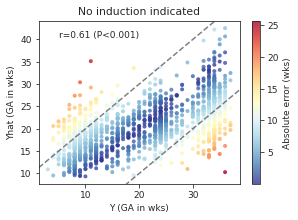

In [13]:
# parse data and plot
y = md.loc[(~md['any_induction']), 'y']
yhat = md.loc[(~md['any_induction']), 'yhat']
error = md.loc[(~md['any_induction']), 'error']

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3))
im = ax.scatter(y, yhat, c=error.abs(), cmap='RdYlBu_r', linewidth=0, s=16, alpha=0.8)
fig.colorbar(im, ax=ax, label='Absolute error (wks)')
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.plot([x0, x1], [x0+threshold, x1+threshold], 'k--', alpha=0.5)
ax.plot([x0, x1], [x0-threshold, x1-threshold], 'k--', alpha=0.5)
ax.set_xlim([x0, x1])
ax.set_ylim([y0, y1])
rho, p = spearmanr(y, yhat)
p_txt = 'P={:.2f}'.format(p) if p > 0.001 else 'P<0.001'
ax.text(0.1, 0.9, 'r={:.2f} ({})'.format(rho, p_txt), transform=ax.transAxes) 
ax.set_xlabel('Y (GA in wks)')
ax.set_ylabel('Yhat (GA in wks)')
ax.set_title('No induction indicated')

if savefigs:
    fig.savefig(os.path.join(pfp, 'scatter_yhatVy_NOinduction_v75.pdf'), bbox_inches='tight')

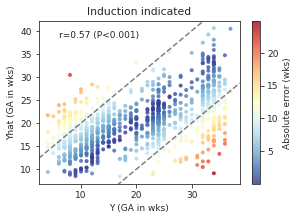

In [14]:
# parse data and plot
y = md.loc[(md['any_induction']), 'y']
yhat = md.loc[(md['any_induction']), 'yhat']
error = md.loc[(md['any_induction']), 'error']

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3))
im = ax.scatter(y, yhat, c=error.abs(), cmap='RdYlBu_r', linewidth=0, s=16, alpha=0.8)
fig.colorbar(im, ax=ax, label='Absolute error (wks)')
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.plot([x0, x1], [x0+threshold, x1+threshold], 'k--', alpha=0.5)
ax.plot([x0, x1], [x0-threshold, x1-threshold], 'k--', alpha=0.5)
ax.set_xlim([x0, x1])
ax.set_ylim([y0, y1])
rho, p = spearmanr(y, yhat)
p_txt = 'P={:.2f}'.format(p) if p > 0.001 else 'P<0.001'
ax.text(0.1, 0.9, 'r={:.2f} ({})'.format(rho, p_txt), transform=ax.transAxes) 
ax.set_xlabel('Y (GA in wks)')
ax.set_ylabel('Yhat (GA in wks)')
ax.set_title('Induction indicated')

if savefigs:
    fig.savefig(os.path.join(pfp, 'scatter_yhatVy_YESinduction_v75.pdf'), bbox_inches='tight')

# enrichment of error groups

In [17]:
from scipy.stats import fisher_exact, chi2_contingency

## all

In [18]:
a = md.loc[(md['Error group']=='Higher-than-actual') & (md['ptb_37wks']==1)].shape[0]
b = md.loc[(md['Error group']=='Higher-than-actual') & (md['ptb_37wks']==0)].shape[0]

c = md.loc[(md['Error group']=='Lower-than-actual') & (md['ptb_37wks']==1) ].shape[0]
d = md.loc[(md['Error group']=='Lower-than-actual') & (md['ptb_37wks']==0) ].shape[0]

tab = np.array([[a, b], [c, d]])
OR, p = fisher_exact(tab)
# OR, p, dof, exp = chi2_contingency(tab)
print(tab)
print('{:.4f} (P={:.4e})'.format(OR, p))

[[ 33 180]
 [ 16 235]]
2.6927 (P=2.1615e-03)


In [19]:
a = md.loc[(md['Error group']=='Lower-than-actual') & (md['ptb_37wks']==1)].shape[0]
b = md.loc[(md['Error group']=='Lower-than-actual') & (md['ptb_37wks']==0)].shape[0]

c = md.loc[(md['Error group']=='Higher-than-actual') & (md['ptb_37wks']==1) ].shape[0]
d = md.loc[(md['Error group']=='Higher-than-actual') & (md['ptb_37wks']==0) ].shape[0]

tab = np.array([[a, b], [c, d]])
OR, p = fisher_exact(tab)
# OR, p, dof, exp = chi2_contingency(tab)
print(tab)
print('{:.4f} (P={:.4e})'.format(OR, p))

[[ 16 235]
 [ 33 180]]
0.3714 (P=2.1615e-03)


## spontaneous

In [20]:
a = md.loc[(md['Error group']=='Higher-than-actual') & (md['ptb_37wks']==1) & (~md['any_induction'])].shape[0]
b = md.loc[(md['Error group']=='Higher-than-actual') & (md['ptb_37wks']==0) & (~md['any_induction'])].shape[0]

c = md.loc[(md['Error group']=='Lower-than-actual') & (md['ptb_37wks']==1) & (~md['any_induction'])].shape[0]
d = md.loc[(md['Error group']=='Lower-than-actual') & (md['ptb_37wks']==0) & (~md['any_induction'])].shape[0]

tab = np.array([[a, b], [c, d]])
OR, p = fisher_exact(tab)
# OR, p, dof, exp = chi2_contingency(tab)
print(tab)
print('{:.4f} (P={:.4e})'.format(OR, p))

[[ 22  97]
 [  9 117]]
2.9485 (P=1.1504e-02)


In [21]:
a = md.loc[(md['Error group']=='Lower-than-actual') & (md['ptb_37wks']==1) & (~md['any_induction'])].shape[0]
b = md.loc[(md['Error group']=='Lower-than-actual') & (md['ptb_37wks']==0) & (~md['any_induction'])].shape[0]

c = md.loc[(md['Error group']=='Higher-than-actual') & (md['ptb_37wks']==1) & (~md['any_induction'])].shape[0]
d = md.loc[(md['Error group']=='Higher-than-actual') & (md['ptb_37wks']==0) & (~md['any_induction'])].shape[0]

tab = np.array([[a, b], [c, d]])
OR, p = fisher_exact(tab)
# OR, p, dof, exp = chi2_contingency(tab)
print(tab)
print('{:.4f} (P={:.4e})'.format(OR, p))

[[  9 117]
 [ 22  97]]
0.3392 (P=1.1504e-02)


## induction

In [22]:
a = md.loc[(md['Error group']=='Higher-than-actual') & (md['ptb_37wks']==1) & (md['any_induction'])].shape[0]
b = md.loc[(md['Error group']=='Higher-than-actual') & (md['ptb_37wks']==0) & (md['any_induction'])].shape[0]

c = md.loc[(md['Error group']=='Lower-than-actual') & (md['ptb_37wks']==1) & (md['any_induction'])].shape[0]
d = md.loc[(md['Error group']=='Lower-than-actual') & (md['ptb_37wks']==0) & (md['any_induction'])].shape[0]

tab = np.array([[a, b], [c, d]])
OR, p = fisher_exact(tab)
# OR, p, dof, exp = chi2_contingency(tab)
print(tab)
print('{:.4f} (P={:.4e})'.format(OR, p))

[[ 11  83]
 [  7 118]]
2.2341 (P=1.3606e-01)


In [23]:
a = md.loc[(md['Error group']=='Lower-than-actual') & (md['ptb_37wks']==1) & (md['any_induction'])].shape[0]
b = md.loc[(md['Error group']=='Lower-than-actual') & (md['ptb_37wks']==0) & (md['any_induction'])].shape[0]

c = md.loc[(md['Error group']=='Higher-than-actual') & (md['ptb_37wks']==1) & (md['any_induction'])].shape[0]
d = md.loc[(md['Error group']=='Higher-than-actual') & (md['ptb_37wks']==0) & (md['any_induction'])].shape[0]

tab = np.array([[a, b], [c, d]])
OR, p = fisher_exact(tab)
# OR, p, dof, exp = chi2_contingency(tab)
print(tab)
print('{:.4f} (P={:.4e})'.format(OR, p))

[[  7 118]
 [ 11  83]]
0.4476 (P=1.3606e-01)


### try perm test

In [18]:
# definitions

def md_group_diffs(df, voi={'ptb_37wks': 'categorical',
                            'GA': 'continuous'}, 
                   groupby='Error group',
                   ratio_only=False,
                   out_file=None):
    
    def pd_chisq(df, feat, groupby='Error group'):
        from scipy.stats import chi2_contingency
        obs = df.groupby([groupby, feat]).size().unstack(fill_value=0)
        try:
            chi2, p, dof, expected = chi2_contingency(obs)
        except ValueError:
            chi2, p, dof, expected = chi2_contingency(obs + 1) # add fake observation to avoid 0s
        return p, obs, expected
    
    def pd_kruskalwallis(df, feat, groupby='Error group'):
        from scipy.stats import kruskal
        size = []
        for i, g in enumerate(df[groupby].unique()):
            dt = df.loc[df[groupby]==g, feat].to_numpy()
            size.append(dt.shape[0])
            if i==0:
                X = dt
            else:
                X = np.concatenate((X, dt))
        X = np.split(X, np.cumsum(size[:-1]))
        statistic, p = kruskal(*X)
        return p
    
    # main block
    results = {g: {} for g in voi.keys()}
    for g, dtype in voi.items():

        if dtype == 'categorical':
            p, obs, expected = pd_chisq(df, g, groupby=groupby)
            expected = pd.DataFrame(expected, 
                                    index=obs.index.to_list(), 
                                    columns=obs.columns.to_list())
            total_obs = sum([v2 for k,v1 in obs.to_dict().items() for v2 in v1.values()])
            total_exp = sum([v2 for k,v1 in expected.to_dict().items() for v2 in v1.values()])
            p_obs = obs.to_dict()
            p_exp = expected.to_dict()
            for k in p_obs.keys():
                p_obs[k] = {k:v/total_obs for k,v in p_obs[k].items()}
                p_exp[k] = {k:v/total_exp for k,v in p_exp[k].items()}
            results[g] = {'Variable': g, 'P': p, 
                   'Tasktype': 'Classification', 
                   'Observed': obs.to_dict(),
                   'Expected': expected.to_dict(),
                   'pObserved': p_obs, 
                   'pExpected': p_exp,}
        else:
            p = pd_kruskalwallis(df, g, groupby=groupby)
            results[g] = {
                'Variable': g, 'P': p,
                'Tasktype': 'Classification', 
                'Observed': {'q{}'.format(i):df.groupby(groupby)[g].quantile(i).to_dict() for i in [0.25, 0.5, 0.75]},
                'Expected': {'q{}'.format(i):df[g].quantile(i) for i in [0.25, 0.5, 0.75]},
                'log2_grpVall' : {str(gg):np.log2(df.loc[df[groupby]==gg, g].mean()) - np.log2(df[g].mean()) for gg in df[groupby].unique()},
            }
    return results


def sample_metric(df, 
                  voi={'ptb_37wks': 'categorical','GA': 'continuous'}, 
                  value=None, n_samples=200, groupby='Error group'):
    '''ratio of obs/expected

    Arguments:
      value (dict): [optional, Default=None] provide dict with value to select from col of table
    '''
    import random
    df = df.copy(deep=True)
    df[groupby] = df[groupby].astype('category') # to ensure unique val not lost in small sample
    for k, v in voi.items():
        if v == 'categorical':
            df[k] = df[k].astype('category') # to ensure unique val not lost in small sample
    dt = df.sample(n_samples, replace=True)
    grp = dt[groupby].to_list()
    random.shuffle(grp)
    dt['{}_shuffled'.format(groupby)] = grp
    results = {k: {} for k in voi.keys()}
    for i, (k, dtype) in enumerate(voi.items()):
        sub_res = md_group_diffs(dt, {k:voi[k]}, groupby=groupby)[k]
        sub_res_null = md_group_diffs(dt, {k:voi[k]}, groupby='{}_shuffled'.format(groupby))[k]
        if dtype=='categorical':
            # obs
            obs = pd.DataFrame(sub_res['pObserved'])
            exp = pd.DataFrame(sub_res['pExpected'])
            factor = obs/exp
            # null
            obs_null = pd.DataFrame(sub_res_null['pObserved'])
            exp_null = pd.DataFrame(sub_res_null['pExpected'])
            factor_null = obs_null/exp_null
            if value is None:
                idx = np.unravel_index(np.argmax((factor - 1).abs().to_numpy()), factor.shape)
                results[k] = factor[idx[1]].to_dict()
                results['{}_null'.format(k)] = factor_null[idx[1]].to_dict()
            else:
                results[k] = factor[value[k]].to_dict()
                results['{}_null'.format(k)] = factor_null[value[k]].to_dict()
        elif dtype=='continuous':
            results[k] = sub_res['log2_grpVall']
            results['{}_null'.format(k)] = sub_res_null['log2_grpVall']
        else:
            print('wrong dtype specified in voi')
    return results

def get_max_value(df, 
                  voi={'ptb_37wks': 'categorical','GA': 'continuous'},
                  groupby='Error group'):
    value = {}
    for i, (k, dtype) in enumerate(voi.items()):
        sub_res = md_group_diffs(df, {k:voi[k]}, groupby=groupby)[k]
        if dtype=='categorical':
            # obs
            obs = pd.DataFrame(sub_res['pObserved'])
            exp = pd.DataFrame(sub_res['pExpected'])
            factor = obs/exp

            idx = np.unravel_index(np.argmax((factor - 1).abs().to_numpy()), factor.shape)
            value[k] = factor[idx[1]].name
        else:
            continue
    return value


def md_grpdiff_perm_test(df, groupby='Error group',
                         voi={'ptb_37wks': 'categorical'}, 
                         value=None,
                         n_trials=1000,
                         verbose=True, 
                         dataframe=False):
    '''
    Arguments:
      dataframe (bool): [optional, Default=False] return as dataframe? If not, returns dict
      
    '''
    if verbose:
        t_total = time.time()
    results = {k: {} for k in list(voi.keys()) + ['{}_null'.format(kk) for kk in voi.keys()]} # {k: {g: [] for g in df[groupby].unique()} for k in voi.keys()}
    if value is None:
        value_tmp = {}
    for i, (v, dtype) in enumerate(voi.items()):
        for n in range(n_trials):
            if value is None and dtype=='categorical':
                if n==0:
                    value_tmp[v] = get_max_value(df, {v:voi[v]}, groupby=groupby)[v]
                    print('\nvalue used for {}={}\n'.format(v, value_tmp[v]))
                m_n = sample_metric(df, {v:voi[v]}, value=value_tmp, groupby=groupby)
            else:
                m_n = sample_metric(df, {v:voi[v]}, value=value, groupby=groupby)
            for key in m_n.keys():
                for kk, val in m_n[key].items():
                    if n==0:
                        results[key][kk] = [val] 
                    else:
                        results[key][kk].append(val)
            if verbose and n % 100 == 0:
                print(f"through n={n+1} trials and i={i+1} var of {len(list(voi.keys()))} in {time.time()-t_total:.0f}-s")
    if verbose:
        print('\nResults:')
        for k in results.keys():
            print(f"  {k}:")
            for kk, vv in results[k].items():
                print(f"    {kk}\t{np.mean(vv):.2f}")
                
    if dataframe:
        # bar plot from this
        dt = pd.DataFrame()
        for k in results.keys():
            dtt = pd.DataFrame()
            for kk, vv in results[k].items():
                dtt[kk] = vv
            dtt['var'] = k if 'null' not in k else k.split('_null')[0]
            if 'null' in k:
                dtt['dist'] = 'Null'
            else:
                dtt['dist'] = 'Obs'
            dt = dt.append(dtt)
            del dtt
        dt = dt.melt(id_vars=['var', 'dist'], value_name='Ratio', var_name=groupby)
        return dt
    else:
        return results
        

                

#### all

In [24]:
# from wearables.scripts.md_specification import mdpred_voi
# max_categorical_obsVexp_ratio = get_max_value(md, mdpred_voi) # from wearables.scripts.aesthetics import max_categorical_obsVexp_ratio

In [45]:
from scipy.stats import ttest_ind, mannwhitneyu


In [36]:
res = md_grpdiff_perm_test(md, 
                           voi={'ptb_37wks': 'categorical'}, 
                           value=None, verbose=True)
voi={'ptb_37wks': 'categorical'}
for k in voi.keys():
    for kk in ['Higher-than-actual', 'Lower-than-actual', 'lt10wks']:
        a = res[k][kk]
        b = res['{}_null'.format(k)][kk]
        statistic, p = ttest_ind(a, b, equal_var=False)
        print(f"{kk}\tP={p*3:.2e}({wearutils.p_encoder(p)})")


value used for ptb_37wks=1.0

through n=1 trials and i=1 var of 1 in 0-s
through n=101 trials and i=1 var of 1 in 1-s
through n=201 trials and i=1 var of 1 in 2-s
through n=301 trials and i=1 var of 1 in 3-s
through n=401 trials and i=1 var of 1 in 3-s
through n=501 trials and i=1 var of 1 in 4-s
through n=601 trials and i=1 var of 1 in 5-s
through n=701 trials and i=1 var of 1 in 6-s
through n=801 trials and i=1 var of 1 in 7-s
through n=901 trials and i=1 var of 1 in 8-s

Results:
  ptb_37wks:
    Higher-than-actual	1.28
    Lower-than-actual	0.53
    lt10wks	1.03
  ptb_37wks_null:
    Higher-than-actual	1.03
    Lower-than-actual	1.00
    lt10wks	1.00
Higher-than-actual	P=2.00e-16(***)
Lower-than-actual	P=4.97e-86(***)
lt10wks	P=2.84e-16(***)


#### spontaneous

In [37]:
res_spont = md_grpdiff_perm_test(md.loc[~(md['any_induction'])], 
                           voi={'ptb_37wks': 'categorical'}, 
                           value=None, verbose=True)
voi={'ptb_37wks': 'categorical'}
for k in voi.keys():
    for kk in ['Higher-than-actual', 'Lower-than-actual', 'lt10wks']:
        a = res_spont[k][kk]
        b = res_spont['{}_null'.format(k)][kk]
        statistic, p = ttest_ind(a, b, equal_var=False)
        print(f"{kk}\tP={p*3:.2e}({wearutils.p_encoder(p)})")


value used for ptb_37wks=1.0

through n=1 trials and i=1 var of 1 in 0-s
through n=101 trials and i=1 var of 1 in 1-s
through n=201 trials and i=1 var of 1 in 2-s
through n=301 trials and i=1 var of 1 in 3-s
through n=401 trials and i=1 var of 1 in 3-s
through n=501 trials and i=1 var of 1 in 4-s
through n=601 trials and i=1 var of 1 in 5-s
through n=701 trials and i=1 var of 1 in 6-s
through n=801 trials and i=1 var of 1 in 7-s
through n=901 trials and i=1 var of 1 in 8-s

Results:
  ptb_37wks:
    Higher-than-actual	1.13
    Lower-than-actual	0.45
    lt10wks	1.05
  ptb_37wks_null:
    Higher-than-actual	1.02
    Lower-than-actual	1.00
    lt10wks	1.00
Higher-than-actual	P=9.72e-06(***)
Lower-than-actual	P=2.31e-137(***)
lt10wks	P=3.61e-52(***)


#### any induction

In [38]:
res_ind = md_grpdiff_perm_test(md.loc[(md['any_induction'])], 
                           voi={'ptb_37wks': 'categorical'}, 
                           value=None, verbose=True)
voi={'ptb_37wks': 'categorical'}
for k in voi.keys():
    for kk in ['Higher-than-actual', 'Lower-than-actual', 'lt10wks']:
        a = res_ind[k][kk]
        b = res_ind['{}_null'.format(k)][kk]
        statistic, p = ttest_ind(a, b, equal_var=False)
        print(f"{kk}\tP={p*3:.2e}({wearutils.p_encoder(p)})")


value used for ptb_37wks=1.0

through n=1 trials and i=1 var of 1 in 0-s
through n=101 trials and i=1 var of 1 in 1-s
through n=201 trials and i=1 var of 1 in 2-s
through n=301 trials and i=1 var of 1 in 3-s
through n=401 trials and i=1 var of 1 in 3-s
through n=501 trials and i=1 var of 1 in 4-s
through n=601 trials and i=1 var of 1 in 5-s
through n=701 trials and i=1 var of 1 in 6-s
through n=801 trials and i=1 var of 1 in 7-s
through n=901 trials and i=1 var of 1 in 8-s

Results:
  ptb_37wks:
    Higher-than-actual	1.81
    Lower-than-actual	0.87
    lt10wks	0.92
  ptb_37wks_null:
    Higher-than-actual	1.04
    Lower-than-actual	1.02
    lt10wks	0.99
Higher-than-actual	P=6.72e-55(***)
Lower-than-actual	P=4.99e-06(***)
lt10wks	P=2.73e-22(***)


### viz perm test

In [47]:
dist_cmap = {'Null': '#2F5061', 'Obs': '#E57F84'}
savefigs = True

In [48]:
# bar plot from this
def res2df(res, ):
    dt = pd.DataFrame()
    for k in res.keys():
        dtt = pd.DataFrame()
        for kk, vv in res[k].items():
            dtt[kk] = vv
        dtt['var'] = k if 'null' not in k else k.split('_null')[0]
        if 'null' in k:
            dtt['dist'] = 'Null'
        else:
            dtt['dist'] = 'Obs'
        dt = dt.append(dtt)
        del dtt
    return dt.melt(id_vars=['var', 'dist'], value_name='Ratio', var_name='Error group')

#### spont

In [49]:
dt = res2df(res_spont)

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


MannwhitneyuResult(statistic=253875.5, pvalue=1.292408950038633e-81)
log2 FC: -0.9177172171940733


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


MannwhitneyuResult(statistic=389039.5, pvalue=4.162462227331371e-18)
log2 FC: 0.318717474466595


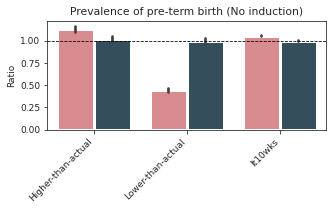

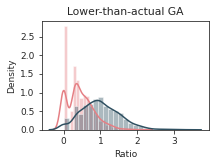

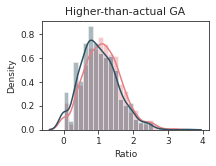

In [50]:


fig, ax = plt.subplots(1, 1, figsize=(5, 2))
sns.barplot(x='Error group', y='Ratio', hue='dist', data=dt, palette=dist_cmap, ax=ax, linewidth=3)
# ax.plot([*ax.get_xlim()], [1.0, 1.0], 'k--', linewidth=0.8, zorder=0)
ax.axhline(1.0, linewidth=0.8, color='k', linestyle='--')
ax.legend().set_visible(False)
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Prevalence of pre-term birth (No induction)')
if savefigs:
    fig.savefig(os.path.join(pfp, 'barplot_prev_ptb_v75_spont.pdf'), bbox_inches='tight',)

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
sns.distplot(dt.loc[(dt['dist']=='Obs') & (dt['Error group']=='Lower-than-actual'), 'Ratio'], color=dist_cmap['Obs'], ax=ax)
sns.distplot(dt.loc[(dt['dist']=='Null') & (dt['Error group']=='Lower-than-actual'), 'Ratio'], color=dist_cmap['Null'], ax=ax)
ax.set_title('Lower-than-actual GA')
a = res['ptb_37wks']['Lower-than-actual']
b = res['ptb_37wks_null']['Lower-than-actual']
print(mannwhitneyu(a, b))
print('log2 FC:', np.log2(np.mean(a)) - np.log2(np.mean(b)))
if savefigs:
    fig.savefig(os.path.join(pfp, 'distplot_lowerthanactual_obsVnull_v75_spont.pdf'), bbox_inches='tight')

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
sns.distplot(dt.loc[(dt['dist']=='Obs') & (dt['Error group']=='Higher-than-actual'), 'Ratio'], color=dist_cmap['Obs'], ax=ax)
sns.distplot(dt.loc[(dt['dist']=='Null') & (dt['Error group']=='Higher-than-actual'), 'Ratio'], color=dist_cmap['Null'], ax=ax)
ax.set_title('Higher-than-actual GA')
a = res['ptb_37wks']['Higher-than-actual']
b = res['ptb_37wks_null']['Higher-than-actual']
print(mannwhitneyu(a, b))
print('log2 FC:', np.log2(np.mean(a)) - np.log2(np.mean(b)))
if savefigs:
    fig.savefig(os.path.join(pfp, 'distplot_Higherthanactual_obsVnull_v75_spont.pdf'), bbox_inches='tight')

#### ind

In [51]:
dt = res2df(res_ind)


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


MannwhitneyuResult(statistic=253875.5, pvalue=1.292408950038633e-81)
log2 FC: -0.9177172171940733


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


MannwhitneyuResult(statistic=389039.5, pvalue=4.162462227331371e-18)
log2 FC: 0.318717474466595


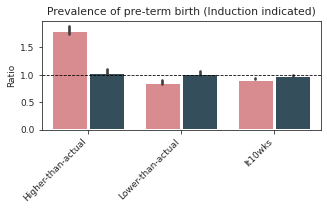

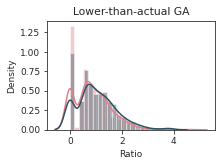

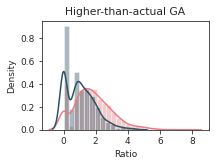

In [52]:

fig, ax = plt.subplots(1, 1, figsize=(5, 2))
sns.barplot(x='Error group', y='Ratio', hue='dist', data=dt, palette=dist_cmap, ax=ax, linewidth=3)
# ax.plot([*ax.get_xlim()], [1.0, 1.0], 'k--', linewidth=0.8, zorder=0)
ax.axhline(1.0, linewidth=0.8, color='k', linestyle='--')
ax.legend().set_visible(False)
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Prevalence of pre-term birth (Induction indicated)')
if savefigs:
    fig.savefig(os.path.join(pfp, 'barplot_prev_ptb_v75_ind.pdf'), bbox_inches='tight',)

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
sns.distplot(dt.loc[(dt['dist']=='Obs') & (dt['Error group']=='Lower-than-actual'), 'Ratio'], color=dist_cmap['Obs'], ax=ax)
sns.distplot(dt.loc[(dt['dist']=='Null') & (dt['Error group']=='Lower-than-actual'), 'Ratio'], color=dist_cmap['Null'], ax=ax)
ax.set_title('Lower-than-actual GA')
a = res['ptb_37wks']['Lower-than-actual']
b = res['ptb_37wks_null']['Lower-than-actual']
print(mannwhitneyu(a, b))
print('log2 FC:', np.log2(np.mean(a)) - np.log2(np.mean(b)))
if savefigs:
    fig.savefig(os.path.join(pfp, 'distplot_lowerthanactual_obsVnull_v75_ind.pdf'), bbox_inches='tight')

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
sns.distplot(dt.loc[(dt['dist']=='Obs') & (dt['Error group']=='Higher-than-actual'), 'Ratio'], color=dist_cmap['Obs'], ax=ax)
sns.distplot(dt.loc[(dt['dist']=='Null') & (dt['Error group']=='Higher-than-actual'), 'Ratio'], color=dist_cmap['Null'], ax=ax)
ax.set_title('Higher-than-actual GA')
a = res['ptb_37wks']['Higher-than-actual']
b = res['ptb_37wks_null']['Higher-than-actual']
print(mannwhitneyu(a, b))
print('log2 FC:', np.log2(np.mean(a)) - np.log2(np.mean(b)))
if savefigs:
    fig.savefig(os.path.join(pfp, 'distplot_Higherthanactual_obsVnull_v75_ind.pdf'), bbox_inches='tight')

# actual performance numbers btw grps

## spontaneous

In [60]:
# print effect size and P-value 
def p_encoder(p):
    if p > 0.05:
        label = 'n.s.' # n.s.
    elif p <= 0.001:
        label = '***'
    elif p <= 0.05 and p > 0.01:
        label = '*'
    elif p <= 0.01 and p > 0.001:
        label = '**'
    else: 
        label = 'Unclassified'
    return label

def print_cont_pval(x, y, n_comparisons=1):
    print('<x>: {:.2e}\t<y>: {:.2e}\t<x>-<y>: {:.2e}'.format(np.mean(x), np.mean(y), np.mean(x) - np.mean(y)))
    stat, p = mannwhitneyu(x, y)
    p = p*n_comparisons
    print('P: {:.2e}\t{}'.format(p, p_encoder(p)))
    return stat, p

In [63]:
split_cmap = {'train': '#4297A0', 'test': '#F4EAE6'}
savefigs = True

In [64]:
df = md.loc[~(md['any_induction'])]

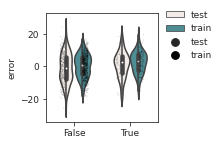

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(2,2))
ptb_cmap = {False: '#2F5061', True: '#E57F84'}
# IS, since not sig (see table 1)
# sns.boxplot(x='Pre-term birth', y='error', hue='split', data=df, width=0.6, palette=split_cmap, ax=ax, dodge=True)
sns.violinplot(x='Pre-term birth', y='error', hue='split', data=df.loc[df['split']!='val', :], width=0.6, palette=split_cmap, ax=ax, dodge=True)
sns.stripplot(x='Pre-term birth', y='error', hue='split', dodge=True, data=df.loc[df['split']!='val', :], color='k', s=1, alpha=0.25, ax=ax, rasterized=True)
# PQSI, since sig (see table 1)
# sns.boxplot(x='Pre-term birth', y='PQSI', width=0.6, data=df, palette=ptb_cmap, ax=ax[1])
# sns.stripplot(x='Pre-term birth', y='PQSI', hue='Pre-term birth', data=df, palette=ptb_cmap, s=2, ax=ax[1], rasterized=True)
ax.set_xlabel('')
ax.legend(bbox_to_anchor=(1, 1.1))

if savefigs:
    fig.savefig(os.path.join(pfp, 'violinplot_error_v_testtrain_ptbyn_v75_spont.pdf'), bbox_inches='tight', dpi=600)

In [66]:
print_cont_pval(df.loc[(df['split']=='train') & (df['Pre-term birth']==True), 'error'], 
                df.loc[(df['split']=='train') & (df['Pre-term birth']==False), 'error'], 
                n_comparisons=1)
print_cont_pval(df.loc[(df['split']=='test') & (df['Pre-term birth']), 'error'], 
                df.loc[(df['split']=='test') & ~(df['Pre-term birth']), 'error'], 
                n_comparisons=1)

<x>: 2.45e+00	<y>: 2.74e-01	<x>-<y>: 2.17e+00
P: 8.99e-04	***
<x>: 1.10e+00	<y>: -9.42e-01	<x>-<y>: 2.04e+00
P: 4.46e-02	*


(8366.0, 0.04455123752151666)

## induction

In [67]:
df = md.loc[(md['any_induction'])]

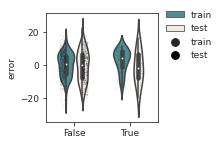

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(2,2))
ptb_cmap = {False: '#2F5061', True: '#E57F84'}
# IS, since not sig (see table 1)
# sns.boxplot(x='Pre-term birth', y='error', hue='split', data=df, width=0.6, palette=split_cmap, ax=ax, dodge=True)
sns.violinplot(x='Pre-term birth', y='error', hue='split', data=df.loc[df['split']!='val', :], width=0.6, palette=split_cmap, ax=ax, dodge=True)
sns.stripplot(x='Pre-term birth', y='error', hue='split', dodge=True, data=df.loc[df['split']!='val', :], color='k', s=1, alpha=0.25, ax=ax, rasterized=True)
# PQSI, since sig (see table 1)
# sns.boxplot(x='Pre-term birth', y='PQSI', width=0.6, data=df, palette=ptb_cmap, ax=ax[1])
# sns.stripplot(x='Pre-term birth', y='PQSI', hue='Pre-term birth', data=df, palette=ptb_cmap, s=2, ax=ax[1], rasterized=True)
ax.set_xlabel('')
ax.legend(bbox_to_anchor=(1, 1.1))

if savefigs:
    fig.savefig(os.path.join(pfp, 'violinplot_error_v_testtrain_ptbyn_v75_ind.pdf'), bbox_inches='tight', dpi=600)

In [69]:
print_cont_pval(df.loc[(df['split']=='train') & (df['Pre-term birth']==True), 'error'], 
                df.loc[(df['split']=='train') & (df['Pre-term birth']==False), 'error'], 
                n_comparisons=1)
print_cont_pval(df.loc[(df['split']=='test') & (df['Pre-term birth']), 'error'], 
                df.loc[(df['split']=='test') & ~(df['Pre-term birth']), 'error'], 
                n_comparisons=1)

<x>: 2.64e+00	<y>: 7.00e-02	<x>-<y>: 2.57e+00
P: 9.76e-03	**
<x>: -1.49e+00	<y>: -5.55e-01	<x>-<y>: -9.35e-01
P: 3.45e-01	n.s.


(2227.0, 0.3446701748478786)

## all

In [70]:
print_cont_pval(md.loc[~(md['any_induction']), 'error'], 
                md.loc[(md['any_induction']), 'error'], 
                n_comparisons=1)

<x>: 2.25e-01	<y>: -1.13e-01	<x>-<y>: 3.38e-01
P: 2.12e-01	n.s.


(638618.5, 0.2123612160235463)

In [71]:
print_cont_pval(md.loc[~(md['any_induction']), 'error'], 
                md['error'], 
                n_comparisons=1)

<x>: 2.25e-01	<y>: 7.96e-02	<x>-<y>: 1.46e-01
P: 3.38e-01	n.s.


(1500603.0, 0.33796609170609987)

In [72]:
print_cont_pval(md.loc[(md['any_induction']), 'error'], 
                md['error'], 
                n_comparisons=1)

<x>: -1.13e-01	<y>: 7.96e-02	<x>-<y>: -1.93e-01
P: 3.07e-01	n.s.


(1130650.5, 0.3072071464593056)

# bias in group splitting?

## tables

In [ ]:
# USE CODE FOR COHORT PAPSDR 

# OLD CODE

# md differences across err grp

In [16]:
# grab list of vars to predict (mdpred_voi)
from wearables.scripts.md_specification import mdpred_voi

In [17]:
import importlib
importlib.reload(wearutils)

<module 'wearables.scripts.utils' from '/home/ngrav/project/wearables/scripts/utils.py'>

In [18]:
resknn10 = loadpkl(os.path.join(pfp, 'md_predictability_knn_10wk.pkl'))
# resknn8 = loadpkl(os.path.join(pfp, 'md_predictability_knn_8wk.pkl'))

In [19]:

moi = wearutils.metric_list(resknn10, mdpred_voi, top1=True) #, clf_metric='balanced_acc')
# moi = wearutils.metric_list(resknn8, mdpred_voi)

In [26]:
savefigs = False

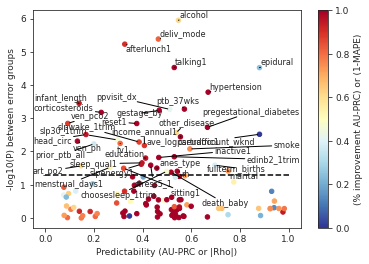

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# p_threshold = -np.log10(0.05/len(mdpred_voi.keys())) # bonferroni
p_threshold = -np.log10(0.05)
clip_color=True
texts = []
x, y, c = [], [], []
for k in moi.keys():
    x.append(moi[k][1])
    y.append(moi[k][0])
    c.append(moi[k][2])
    if moi[k][0] > p_threshold:
        texts.append(ax.text(moi[k][1], moi[k][0], k, size=8))
im = ax.scatter(x, y, c=c, cmap='RdYlBu_r', s=20, vmin=0, vmax=1)
fig.colorbar(im, ax=ax, label='(% improvement AU-PRC) or (1-MAPE)')
ax.plot([0, 1], [p_threshold, p_threshold], 'k--')
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k'), force_text=(0.12, 0.3))
ax.set_xlabel('Predictability (AU-PRC or |Rho|)')
ax.set_ylabel('-log10(P) between error groups')

if savefigs:
    fig.savefig(os.path.join(pfp, 'scatter_errgroupdiffVpredictability_knn_v72.pdf'), bbox_inches='tight')

# corrnet

In [21]:
from scipy.stats import spearmanr
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as sklmetrics
from sklearn.exceptions import ConvergenceWarning

In [22]:
def tabular_corrnet(md, mdpred_voi, edge_w_threshold=0.5):
    '''Calculate correlations (will need to take absolute value) for cont-cont using Spearman's rho,
         cont-cat using logistic regression on the categorical (max of balanced acc, adj., i.e., Youden's J),
         and Goodman Kruskal gamma for cat-cat variable comparisons.
    
    Arguments:
      md (pd.DataFrame): of mixed categorical and continuous variables. Must have a split column specifying train and
        test splits so logistic regression can be run
      mdpred_voi (dict): specify name of column in md as a key and the type of var as a value, accepts 'continuous' or 'categorical' 
        values in order to trigger the appropriate analysis.
        
    Returns:
      pd.DataFrame, nx.Graph
    '''
    from scipy.stats import spearmanr
    from sklearn.linear_model import LogisticRegression
    import sklearn.metrics as sklmetrics
    from sklearn.exceptions import ConvergenceWarning
    variables = list(mdpred_voi.keys())
    df = pd.DataFrame(index=variables, columns=variables)
    for i in range(len(variables)):
        for j in range(len(variables)):
            if i<=j:
                continue
            else:
                k, kk = variables[i], variables[j]
                v, vv = mdpred_voi[k], mdpred_voi[kk]
                if v == 'continuous' and vv == 'continuous':
                    # spearman's rho 
                    rho, p = spearmanr(md[k], md[kk])
                    df.loc[k, kk] = rho
                    df.loc[kk, k] = rho
                elif (v == 'continuous' and vv == 'categorical') or (v == 'categorical' and vv == 'continuous'):
                    # logistic regression
                    contvar = k if v == 'continuous' else kk
                    catvar = k if v == 'categorical' else kk
                    X_train = md.loc[md['split']=='train', contvar].to_numpy(dtype=np.float64).reshape(-1, 1)
                    X_test = md.loc[md['split']=='test', contvar].to_numpy(dtype=np.float64).reshape(-1, 1)
                    y_train = md.loc[md['split']=='train', catvar]
                    y_test = md.loc[md['split']=='test', catvar]
                    if len(y_train.unique()) < 1:
                        print(f"only one val found for {catvar}")
                    elif len(y_train.unique()) > 2:
                        y_train = y_train.to_numpy(dtype=int)
                        y_test = y_test.to_numpy(dtype=int)
                        y_train_wide = np.zeros((y_train.shape[0], len(np.unique(y_train))), dtype=int)
                        y_test_wide = np.zeros((y_test.shape[0], len(np.unique(y_train))), dtype=int)
                        y_train_wide[np.arange(y_train.shape[0]), y_train] = 1
                        y_test_wide[np.arange(y_test.shape[0]), y_test] = 1

                        y_train = y_train_wide
                        del y_train_wide
                        y_test = y_test_wide 
                        del y_test_wide
                    else:
                        y_train = y_train.to_numpy(dtype=int).reshape(-1, 1)
                        y_test = y_test.to_numpy(dtype=int).reshape(-1, 1)
                    balanced_acc = [] # Youden's J
                    for j in range(y_train.shape[1]):
                        lr = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.1)
                        lr.fit(X_train, y_train[:, j])
                        balanced_acc.append(
                            sklmetrics.balanced_accuracy_score(y_test[:, j], lr.predict(X_test), adjusted=True)
                        )
                    df.loc[k, kk] = np.max(balanced_acc) # max agg?
                    df.loc[kk, k] = np.max(balanced_acc) # max agg?
                else:
                    # cat v. cat
                    GKgamma = wearerr.goodmanKruskalgamma(md, k, kk)
                    df.loc[k, kk] = GKgamma 
                    df.loc[kk, k] = GKgamma
    return df
            
                
            

In [23]:
df = tabular_corrnet(md, mdpred_voi)

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/matrix.py:619: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


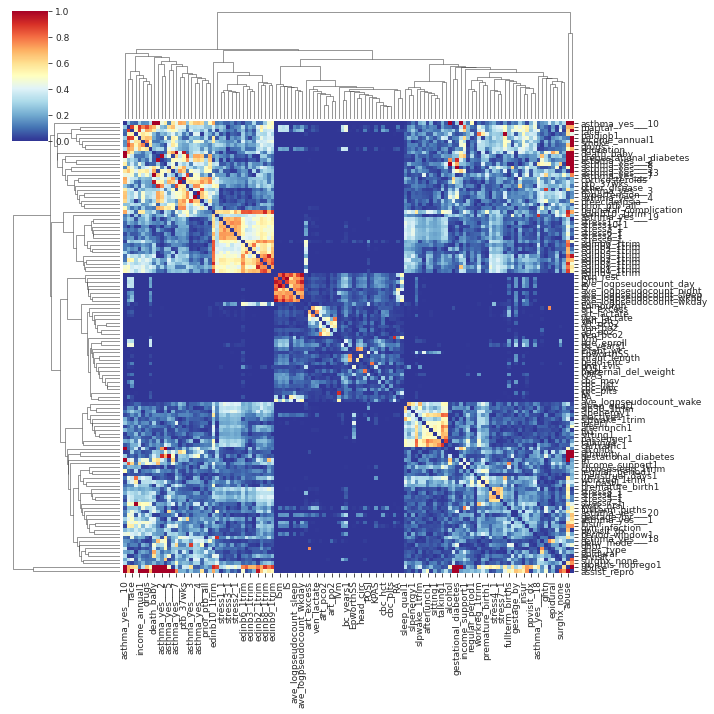

In [24]:
p = sns.clustermap(df.fillna(0).abs(), yticklabels=1, xticklabels=2, cmap='RdYlBu_r')
p.savefig(os.path.join(pfp, 'md_corrnet_v72.pdf'), bbox_inches='tight')


## pval only

Size and color by pval across error groups

In [25]:
corr_threshold = 0.6
G = nx.Graph()
for k, v in moi.items():
    G.add_node(k, size=v[0], color=v[0])
variables = df.columns.to_list()
for i in range(len(variables)):
    for j in range(len(variables)):
        if i <= j: 
            continue
        else: 
            k, kk = variables[i], variables[j]
            w = np.abs(df.loc[k, kk])
            if w > corr_threshold:
                G.add_edge(k, kk, weight=w)
G.remove_nodes_from(list(nx.isolates(G)))
pos = nx.spring_layout(G, k=0.5)


In [26]:
p_threshold = -np.log10(0.05)

In [27]:
def range_scale(x, min_target=100, max_target=300):
    return ((x - np.min(x)) / (np.max(x) - np.min(x)))*(max_target - min_target) + min_target

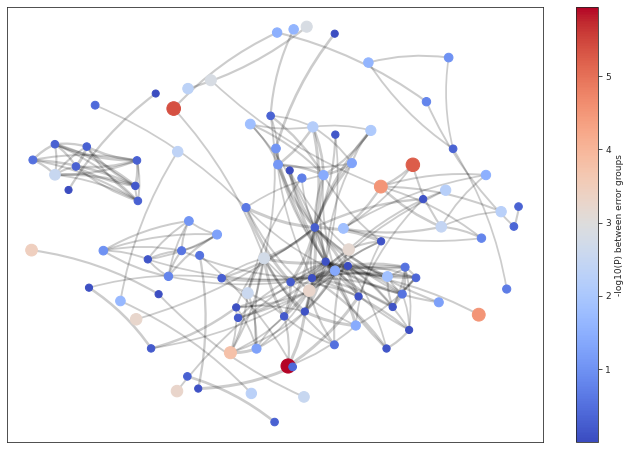

In [28]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
node_sizes = [G.nodes[n]['size'] for n in G.nodes()]
im = nx.draw_networkx_nodes(
    G, pos=pos, label=False,
    nodelist=G.nodes(),
    node_color=[G.nodes[n]['color'] for n in G.nodes()],
    node_size=range_scale([G.nodes[n]['size'] for n in G.nodes()], min_target=50, max_target=200),
    cmap='coolwarm',
    ax=ax)
for edge in G.edges:
    ax.annotate('',
                xy=pos[edge[0]], 
                xytext=pos[edge[1]], 
                xycoords='data',
                textcoords='data',
                arrowprops=dict(arrowstyle="-", color='k',
                                linewidth=((np.exp(G.edges[edge]['weight']) - np.exp(0))/(np.exp(1) - np.exp(0)))*2.5+0.5, 
                                alpha=0.2,
                                shrinkA=0.5, shrinkB=0.5,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad=-0.1",),
                zorder=0,
                )
if False:
    # show tecxt that is sig only?
    texts = []
    for k in moi.keys():
        if moi[k][0] > p_threshold and k in list(G.nodes):
            texts.append(ax.text(pos[k][0], pos[k][1], k, size=9))
    # adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k'), force_text=(0.12, 0.3))
    adjust_text(texts, force_text=(0.12, 0.3))
fig.colorbar(im, ax=ax, label='-log10(P) between error groups')
fig.savefig(os.path.join(pfp, 'corrnet_sizePval_btwerrgrp_sigtxt_V71.pdf'))

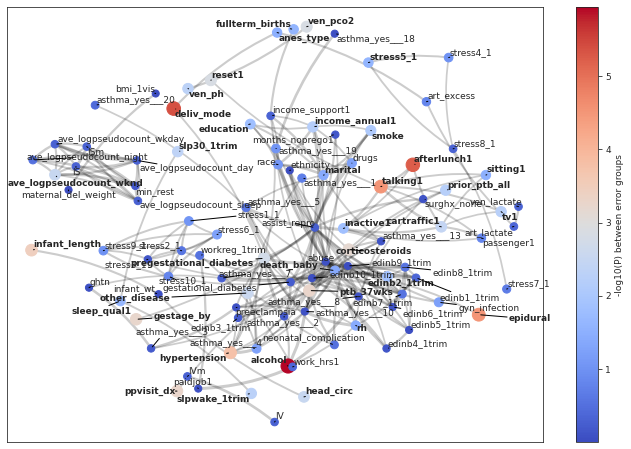

In [29]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
im = nx.draw_networkx_nodes(
    G, pos=pos, label=False,
    nodelist=G.nodes(),
    node_color=[G.nodes[n]['color'] for n in G.nodes()],
    node_size=range_scale([G.nodes[n]['size'] for n in G.nodes()], min_target=50, max_target=200),
    cmap='coolwarm',
    ax=ax)
for edge in G.edges:
    ax.annotate('',
                xy=pos[edge[0]], 
                xytext=pos[edge[1]], 
                xycoords='data',
                textcoords='data',
                arrowprops=dict(arrowstyle="-", color='k',
                                linewidth=((np.exp(G.edges[edge]['weight']) - np.exp(0))/(np.exp(1) - np.exp(0)))*2.5+0.5, 
                                alpha=0.2,
                                shrinkA=0.5, shrinkB=0.5,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad=-0.1",),
                zorder=0,
                )
if True:
    texts = []
    # all 
    for k in G.nodes():
        if moi[k][0] > p_threshold:
            weight='bold'
        else:
            weight='normal'
        texts.append(ax.text(pos[k][0], pos[k][1], k, size=9, weight=weight))
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k'), force_text=(0.12, 0.3))
fig.colorbar(im, ax=ax, label='-log10(P) between error groups')
fig.savefig(os.path.join(pfp, 'corrnet_sizePval_btwerrgrp_alltxt_v72.pdf'))

## pval and predictability

In [30]:
# update graph
for k in G.nodes:
    G.nodes[k]['size'] = moi[k][2] if not np.isnan(moi[k][2]) or np.isinf(moi[k][2]) else 0
    G.nodes[k]['color'] = moi[k][0]


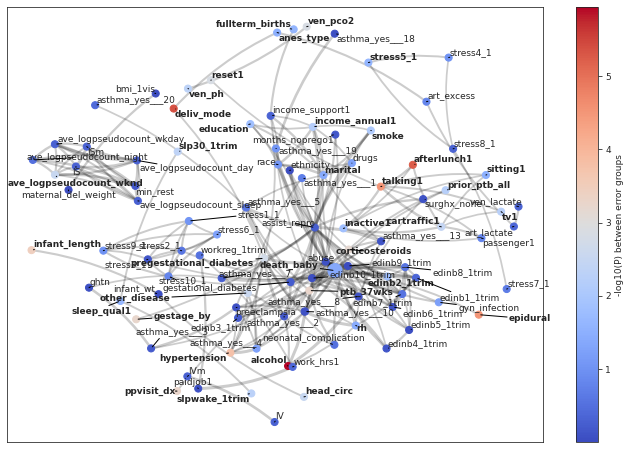

In [31]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
node_sizes = [G.nodes[n]['size'] for n in G.nodes()]
im = nx.draw_networkx_nodes(
    G, pos=pos, label=False,
    nodelist=G.nodes(),
    node_color=[G.nodes[n]['color'] for n in G.nodes()],
    node_size=range_scale(np.exp([G.nodes[n]['size'] for n in G.nodes()]), min_target=50, max_target=200),
    cmap='coolwarm',
    ax=ax)
for edge in G.edges:
    ax.annotate('',
                xy=pos[edge[0]], 
                xytext=pos[edge[1]], 
                xycoords='data',
                textcoords='data',
                arrowprops=dict(arrowstyle="-", color='k',
                                linewidth=((np.exp(G.edges[edge]['weight']) - np.exp(0))/(np.exp(1) - np.exp(0)))*2.5+0.5, 
                                alpha=0.2,
                                shrinkA=0.5, shrinkB=0.5,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad=-0.1",),
                zorder=0,
                )
texts = []
# all 
for k in G.nodes():
    if moi[k][0] > p_threshold:
        weight='bold'
    else:
        weight='normal'
    texts.append(ax.text(pos[k][0], pos[k][1], k, size=9, weight=weight))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k'), force_text=(0.12, 0.3))
fig.colorbar(im, ax=ax, label='-log10(P) between error groups')

In [32]:
savefigs = True

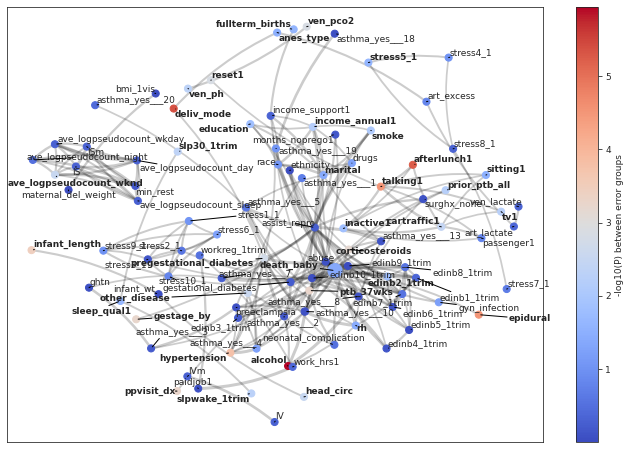

In [33]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
node_sizes = [G.nodes[n]['size'] for n in G.nodes()]
im = nx.draw_networkx_nodes(
    G, pos=pos, label=False,
    nodelist=G.nodes(),
    node_color=[G.nodes[n]['color'] for n in G.nodes()],
    node_size=range_scale(np.exp([G.nodes[n]['size'] for n in G.nodes()]), min_target=50, max_target=200),
    cmap='coolwarm',
    ax=ax)
for edge in G.edges:
    ax.annotate('',
                xy=pos[edge[0]], 
                xytext=pos[edge[1]], 
                xycoords='data',
                textcoords='data',
                arrowprops=dict(arrowstyle="-", color='k',
                                linewidth=((np.exp(G.edges[edge]['weight']) - np.exp(0))/(np.exp(1) - np.exp(0)))*2.5+0.5, 
                                alpha=0.2,
                                shrinkA=0.5, shrinkB=0.5,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad=-0.1",),
                zorder=0,
                )
texts = []
# all 
for k in G.nodes():
    if moi[k][0] > p_threshold:
        weight='bold'
    else:
        weight='normal'
    texts.append(ax.text(pos[k][0], pos[k][1], k, size=9, weight=weight))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k'), force_text=(0.12, 0.3))
fig.colorbar(im, ax=ax, label='-log10(P) between error groups')

if savefigs:
    fig.savefig(os.path.join(pfp, 'mdcorrnet_errgrpP_informativenessSize_v72.pdf'), bbox_inches='tight')

In [34]:
# color by node
from wearables.scripts.aesthetics import md_node_annotation
# md_node_category_cmap = {k:'#'+v for k,v in zip(dt['cat'].value_counts().index, ["171a21","617073","7a93ac","92bceka","afb3f7","8db580","efd6ac","c44900"])}
from wearables.scripts.aesthetics import md_node_category_cmap

In [35]:
# update graph
for k in G.nodes:
    G.nodes[k]['size'] = moi[k][2] if not np.isnan(moi[k][2]) or np.isinf(moi[k][2]) else 0
    G.nodes[k]['color'] = moi[k][0]

In [36]:
# make a joint df for bar plotting

In [37]:
dt = pd.Series(md_node_annotation).reset_index().rename(columns={'index':'var', 0:'cat'})
dt['cat'].value_counts()

Comorbidities                    21
Procedural                       17
Pregnancy outcome                17
Sleep-quality                    16
Social determinants of health    14
Activity-related                 14
Depression-related               13
Stress-related                   10
Name: cat, dtype: int64

In [38]:
md_node_category_cmap = {
    'Pregnancy outcome': '#b0f2b4',
    'Comorbidities': '#baf2e9',
    'Sleep-quality': '#bad7f2',
    'Social determinants of health': '#f2bac9',
    'Activity-related': '#f2e2ba',
    'Depression-related': '#37393a',
    'Procedural': '#f991cc',
    'Stress-related': '#6d696a'
}


In [39]:
dt = dt.merge(pd.DataFrame(pd.DataFrame(moi).T.rename(columns={k:v for k,v in zip(list(range(3)), ['-log10P', 'AU-PRC', 'AU-PRC (%-diff)'])})), 
         left_on='var', right_index=True, how='left')

In [40]:
dtt = pd.DataFrame(columns=dt.columns)
for cat in dt.value_counts('cat').index:
    dtt = dtt.append(dt.loc[dt['cat']==cat, :].sort_values(by='-log10P', ascending=False), ignore_index=True)
dt = dtt 
del dtt

In [41]:
dt.head()

,var,cat,-log10P,AU-PRC,AU-PRC (%-diff)
0,hypertension,Comorbidities,3.785418,0.669416,1.014579
1,pregestational_diabetes,Comorbidities,2.727432,0.666667,1.000088
2,other_disease,Comorbidities,2.563766,0.538430,0.614268
3,prior_ptb_all,Comorbidities,2.227092,0.200380,0.364778
4,fullterm_births,Comorbidities,1.587216,0.697014,0.381180


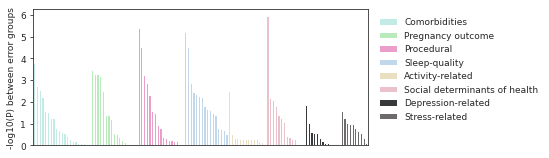

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
sns.barplot(x='var', y='-log10P', data=dt, ax=ax, hue='cat', dodge=False, palette=md_node_category_cmap)
ax.set_xticks([])
ax.set_xlabel('')
ax.set_ylabel('-log10(P) between error groups')
ax.legend(bbox_to_anchor=(1.01, 1))

In [43]:
p_threshold

1.3010299956639813

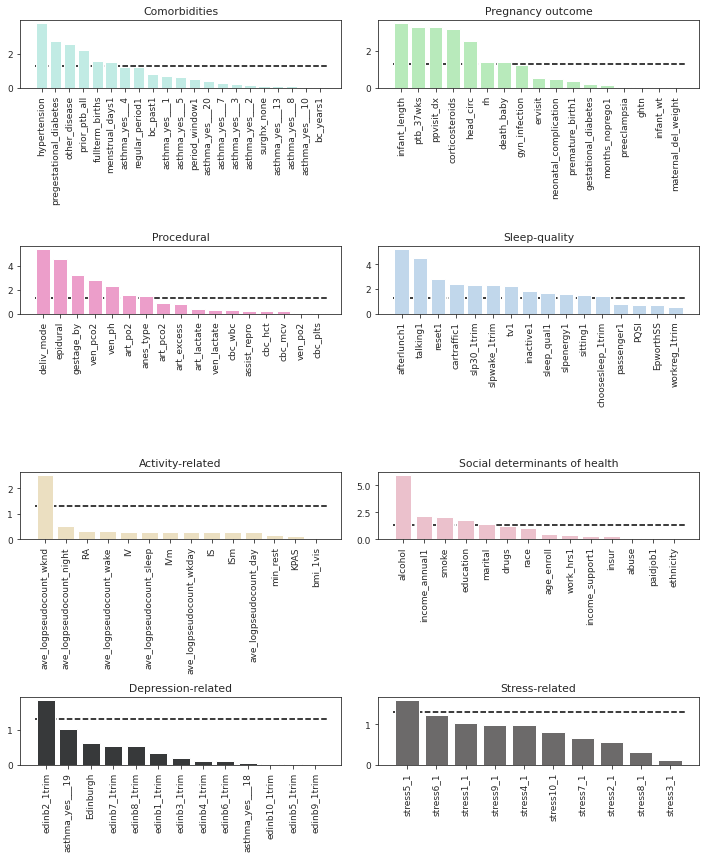

In [44]:
# seperate per grp 
fig = plt.figure(figsize=(10, 12))
for i, cat in enumerate(dt['cat'].unique()):
    ax = fig.add_subplot(4, 2, i+1)
    sns.barplot(x='var', y='-log10P', data=dt.loc[dt['cat']==cat], 
                                                  ax=ax, hue='cat', dodge=False, palette=md_node_category_cmap)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.plot([*ax.get_xlim()], [p_threshold, p_threshold], 'k--', zorder=0)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(cat)
    ax.legend().set_visible(False)
fig.tight_layout()
fig.savefig(os.path.join(pfp, 'barplot_pVvariables_by_cat_v72.pdf'), bbox_inches='tight')

In [45]:
# actually, not the right name in the columns
dt = dt.rename(columns={'AU-PRC': 'AU-PRC or Rho', 'AU-PRC (%-diff)': '%-diff or MAPE'})
dt.head()

,var,cat,-log10P,AU-PRC or Rho,%-diff or MAPE
0,hypertension,Comorbidities,3.785418,0.669416,1.014579
1,pregestational_diabetes,Comorbidities,2.727432,0.666667,1.000088
2,other_disease,Comorbidities,2.563766,0.538430,0.614268
3,prior_ptb_all,Comorbidities,2.227092,0.200380,0.364778
4,fullterm_births,Comorbidities,1.587216,0.697014,0.381180


In [46]:
# re-rank
dtt = pd.DataFrame(columns=dt.columns)
for cat in dt.value_counts('cat').index:
    dtt = dtt.append(dt.loc[dt['cat']==cat, :].sort_values(by='AU-PRC or Rho', ascending=False), ignore_index=True)
dt = dtt 
del dtt

In [47]:
dt.head()

,var,cat,-log10P,AU-PRC or Rho,%-diff or MAPE
0,bc_past1,Comorbidities,0.800944,0.930346,0.127801
1,surghx_none,Comorbidities,0.097508,0.751211,0.307682
2,fullterm_births,Comorbidities,1.587216,0.697014,0.381180
3,hypertension,Comorbidities,3.785418,0.669416,1.014579
4,pregestational_diabetes,Comorbidities,2.727432,0.666667,1.000088


In [48]:
dtt = dt.loc[dt['cat']==cat, :]
x, y, c = dtt['var'], dtt['AU-PRC or Rho'], dtt['%-diff or MAPE']

/tmp/ipykernel_3378071/2706832798.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=45, ha='right')
/tmp/ipykernel_3378071/2706832798.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=45, ha='right')
/tmp/ipykernel_3378071/2706832798.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=45, ha='right')
/tmp/ipykernel_3378071/2706832798.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=45, ha='right')
/tmp/ipykernel_3378071/2706832798.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=45, ha='right')
/tmp/ipykernel_3378071/2706832798.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=45, ha='right')
/tmp/ipyke

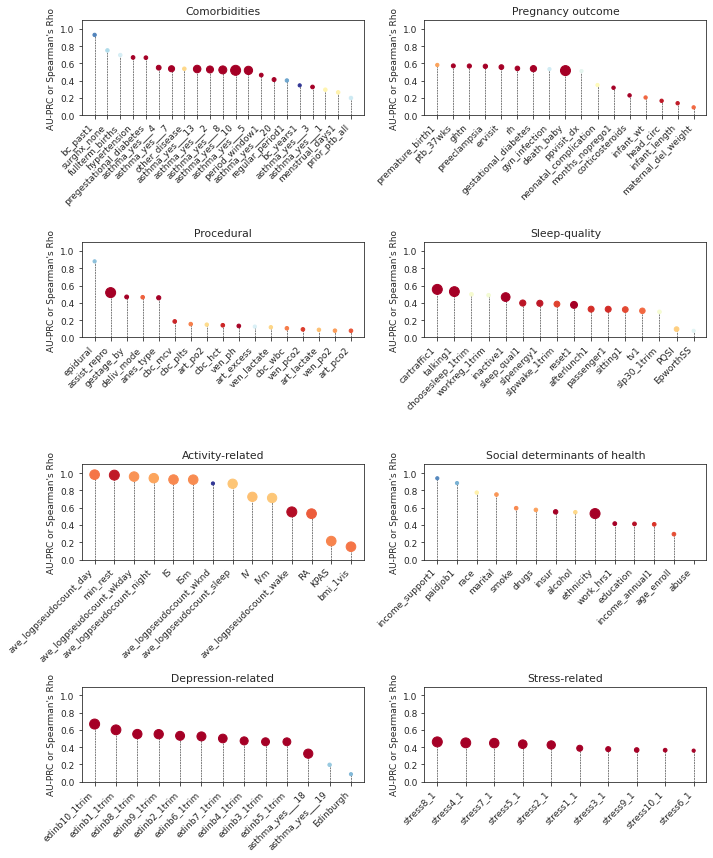

In [49]:
# seperate per grp 
fig = plt.figure(figsize=(10, 12))
for i, cat in enumerate(dt['cat'].unique()):
    ax = fig.add_subplot(4, 2, i+1)
    dtt = dt.loc[dt['cat']==cat, :]
    x, y, c = dtt['var'], dtt['AU-PRC or Rho'], dtt['%-diff or MAPE']
    im = ax.scatter(x, y, c=c, s=range_scale(c, min_target=10, max_target=100), vmin=0, vmax=1, cmap='RdYlBu_r')
    for ii in range(len(x)):
        ax.plot([x.iloc[ii], x.iloc[ii]], [0, y.iloc[ii]], 'k--', linewidth=0.5, zorder=0)
    ax.set_xticklabels(x, rotation=45, ha='right')
#     fig.colorbar(im, ax=ax, label='%-diff or MAPE')
    ax.set_ylabel("AU-PRC or Spearman's Rho")
    ax.set_ylim([0, 1.1])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_title(cat)
fig.tight_layout()
fig.savefig(os.path.join(pfp, 'barplot_AUPRC-RhoVvars_by_cat_v72.pdf'), bbox_inches='tight')

In [51]:
# color corrnet by these groupings and size as informativeness 

In [52]:
# update graph
for k in G.nodes:
    G.nodes[k]['size'] = moi[k][2] if not np.isnan(moi[k][2]) or np.isinf(moi[k][2]) else 0
    G.nodes[k]['color'] = md_node_category_cmap[dt.loc[dt['var']==k, 'cat'].item()]


In [53]:
savefigs = True

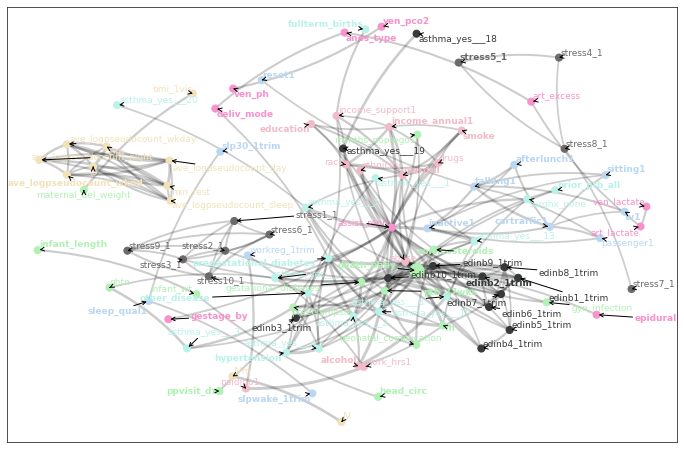

In [54]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
node_sizes = [G.nodes[n]['size'] for n in G.nodes()]
im = nx.draw_networkx_nodes(
    G, pos=pos, label=False,
    nodelist=G.nodes(),
    node_color=[G.nodes[n]['color'] for n in G.nodes()],
    node_size=range_scale(np.exp([G.nodes[n]['size'] for n in G.nodes()]), min_target=50, max_target=200),
#     cmap=md_node_category_cmap,
    ax=ax)
for edge in G.edges:
    ax.annotate('',
                xy=pos[edge[0]], 
                xytext=pos[edge[1]], 
                xycoords='data',
                textcoords='data',
                arrowprops=dict(arrowstyle="-", color='k',
                                linewidth=((np.exp(G.edges[edge]['weight']) - np.exp(0))/(np.exp(1) - np.exp(0)))*2.5+0.5, 
                                alpha=0.2,
                                shrinkA=0.5, shrinkB=0.5,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad=-0.1",),
                zorder=0,
                )
texts = []
# all 
for k in G.nodes():
    if moi[k][0] > p_threshold:
        weight='bold'
    else:
        weight='normal'
    texts.append(ax.text(pos[k][0], pos[k][1], k, size=9, weight=weight, color=md_node_category_cmap[dt.loc[dt['var']==k, 'cat'].item()]))
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='k'), force_text=(0.12, 0.3))
# fig.colorbar(im, ax=ax, label='-log10(P) between error groups')

if savefigs:
    fig.savefig(os.path.join(pfp, 'mdcorrnet_cat_informativenessSize_v72.pdf'), bbox_inches='tight')

# ptb specifics

## permutation tests per group

### (1) What actually is the difference?
- put a number on the higher than actual group

In [55]:
md.head()

,record_id,age_enroll,marital,gestage_by,insur,ethnicity,race,bmi_1vis,prior_ptb_all,fullterm_births,...,KPAS,EpworthSS,Edinburgh,Pre-term birth,id,split,y,yhat,error,Error group
unique_id,,,,,,,,,,,,,,,,,,,,,
2180_12,2180,34.0,1.0,1.0,3.0,0.0,0.0,31.732640,0.0,0.0,...,9.053680,5.0,6.0,False,2180_12,test,12.0,15.189330,3.189330,lt10wks
2148_11,2148,34.0,1.0,2.0,3.0,0.0,0.0,22.406605,0.0,1.0,...,10.266234,9.0,7.0,False,2148_11,train,11.0,19.224419,8.224419,lt10wks
1062_8,1062,31.0,0.0,1.0,5.0,0.0,1.0,40.106270,0.0,0.0,...,9.493074,3.0,5.0,False,1062_8,train,8.0,15.505736,7.505736,lt10wks
1306_7,1306,25.0,0.0,3.0,5.0,0.0,1.0,24.555670,0.0,0.0,...,8.889610,9.0,9.0,False,1306_7,train,7.0,17.990391,10.990391,Higher-than-actual
2003_7,2003,38.0,1.0,1.0,1.0,0.0,1.0,37.804455,0.0,0.0,...,8.984632,8.0,3.0,False,2003_7,train,7.0,19.551502,12.551502,Higher-than-actual


In [56]:
md['hypertension'].value_counts()

0.0    2070
1.0     229
2.0       6
Name: hypertension, dtype: int64

In [57]:
df['hypertension'] = df['hypertension'].astype('category')
df['Error group'] = df['Error group'].astype('category')

KeyError: 'Error group'

In [706]:
dt = df.sample(2)
dt.groupby(['Error group', 'hypertension']).size().unstack(fill_value=0)

In [59]:
def md_group_diffs(df, voi={'ptb_37wks': 'categorical',
                            'GA': 'continuous'}, 
                   groupby='Error group',
                   ratio_only=False,
                   out_file=None):
    
    def pd_chisq(df, feat, groupby='Error group'):
        from scipy.stats import chi2_contingency
        obs = df.groupby([groupby, feat]).size().unstack(fill_value=0)
        try:
            chi2, p, dof, expected = chi2_contingency(obs)
        except ValueError:
            chi2, p, dof, expected = chi2_contingency(obs + 1) # add fake observation to avoid 0s
        return p, obs, expected
    
    def pd_kruskalwallis(df, feat, groupby='Error group'):
        from scipy.stats import kruskal
        size = []
        for i, g in enumerate(df[groupby].unique()):
            dt = df.loc[df[groupby]==g, feat].to_numpy()
            size.append(dt.shape[0])
            if i==0:
                X = dt
            else:
                X = np.concatenate((X, dt))
        X = np.split(X, np.cumsum(size[:-1]))
        statistic, p = kruskal(*X)
        return p
    
    # main block
    results = {g: {} for g in voi.keys()}
    for g, dtype in voi.items():

        if dtype == 'categorical':
            p, obs, expected = pd_chisq(df, g, groupby=groupby)
            expected = pd.DataFrame(expected, 
                                    index=obs.index.to_list(), 
                                    columns=obs.columns.to_list())
            total_obs = sum([v2 for k,v1 in obs.to_dict().items() for v2 in v1.values()])
            total_exp = sum([v2 for k,v1 in expected.to_dict().items() for v2 in v1.values()])
            p_obs = obs.to_dict()
            p_exp = expected.to_dict()
            for k in p_obs.keys():
                p_obs[k] = {k:v/total_obs for k,v in p_obs[k].items()}
                p_exp[k] = {k:v/total_exp for k,v in p_exp[k].items()}
            results[g] = {'Variable': g, 'P': p, 
                   'Tasktype': 'Classification', 
                   'Observed': obs.to_dict(),
                   'Expected': expected.to_dict(),
                   'pObserved': p_obs, 
                   'pExpected': p_exp,}
        else:
            p = pd_kruskalwallis(df, g, groupby=groupby)
            results[g] = {
                'Variable': g, 'P': p,
                'Tasktype': 'Classification', 
                'Observed': {'q{}'.format(i):df.groupby(groupby)[g].quantile(i).to_dict() for i in [0.25, 0.5, 0.75]},
                'Expected': {'q{}'.format(i):df[g].quantile(i) for i in [0.25, 0.5, 0.75]},
                'log2_grpVall' : {str(gg):np.log2(df.loc[df[groupby]==gg, g].mean()) - np.log2(df[g].mean()) for gg in df[groupby].unique()},
            }
    return results


def sample_metric(df, 
                  voi={'ptb_37wks': 'categorical','GA': 'continuous'}, 
                  value=None, n_samples=200, groupby='Error group'):
    '''ratio of obs/expected

    Arguments:
      value (dict): [optional, Default=None] provide dict with value to select from col of table
    '''
    import random
    df = df.copy(deep=True)
    df[groupby] = df[groupby].astype('category') # to ensure unique val not lost in small sample
    for k, v in voi.items():
        if v == 'categorical':
            df[k] = df[k].astype('category') # to ensure unique val not lost in small sample
    dt = df.sample(n_samples, replace=True)
    grp = dt[groupby].to_list()
    random.shuffle(grp)
    dt['{}_shuffled'.format(groupby)] = grp
    results = {k: {} for k in voi.keys()}
    for i, (k, dtype) in enumerate(voi.items()):
        sub_res = md_group_diffs(dt, {k:voi[k]}, groupby=groupby)[k]
        sub_res_null = md_group_diffs(dt, {k:voi[k]}, groupby='{}_shuffled'.format(groupby))[k]
        if dtype=='categorical':
            # obs
            obs = pd.DataFrame(sub_res['pObserved'])
            exp = pd.DataFrame(sub_res['pExpected'])
            factor = obs/exp
            # null
            obs_null = pd.DataFrame(sub_res_null['pObserved'])
            exp_null = pd.DataFrame(sub_res_null['pExpected'])
            factor_null = obs_null/exp_null
            if value is None:
                idx = np.unravel_index(np.argmax((factor - 1).abs().to_numpy()), factor.shape)
                results[k] = factor[idx[1]].to_dict()
                results['{}_null'.format(k)] = factor_null[idx[1]].to_dict()
            else:
                results[k] = factor[value[k]].to_dict()
                results['{}_null'.format(k)] = factor_null[value[k]].to_dict()
        elif dtype=='continuous':
            results[k] = sub_res['log2_grpVall']
            results['{}_null'.format(k)] = sub_res_null['log2_grpVall']
        else:
            print('wrong dtype specified in voi')
    return results

In [60]:
# we need to define a function 
#   that will grab the maximum value observed in the training data
#   then print out that to use in the future (port it to aesthetics)

def get_max_value(df, 
                  voi={'ptb_37wks': 'categorical','GA': 'continuous'},
                  groupby='Error group'):
    value = {}
    for i, (k, dtype) in enumerate(voi.items()):
        sub_res = md_group_diffs(df, {k:voi[k]}, groupby=groupby)[k]
        if dtype=='categorical':
            # obs
            obs = pd.DataFrame(sub_res['pObserved'])
            exp = pd.DataFrame(sub_res['pExpected'])
            factor = obs/exp

            idx = np.unravel_index(np.argmax((factor - 1).abs().to_numpy()), factor.shape)
            value[k] = factor[idx[1]].name
        else:
            continue
    return value

In [61]:
max_categorical_obsVexp_ratio = get_max_value(md, mdpred_voi) # from wearables.scripts.aesthetics import max_categorical_obsVexp_ratio

/tmp/ipykernel_3378071/2724408599.py:59: RuntimeWarning: invalid value encountered in log2
  'log2_grpVall' : {str(gg):np.log2(df.loc[df[groupby]==gg, g].mean()) - np.log2(df[g].mean()) for gg in df[groupby].unique()},


In [62]:
def md_grpdiff_perm_test(df, groupby='Error group',
                         voi={'ptb_37wks': 'categorical'}, 
                         value=None,
                         n_trials=1000,
                         verbose=True, 
                         dataframe=False):
    '''
    Arguments:
      dataframe (bool): [optional, Default=False] return as dataframe? If not, returns dict
      
    '''
    if verbose:
        t_total = time.time()
    results = {k: {} for k in list(voi.keys()) + ['{}_null'.format(kk) for kk in voi.keys()]} # {k: {g: [] for g in df[groupby].unique()} for k in voi.keys()}
    if value is None:
        value_tmp = {}
    for i, (v, dtype) in enumerate(voi.items()):
        for n in range(n_trials):
            if value is None and dtype=='categorical':
                if n==0:
                    value_tmp[v] = get_max_value(df, {v:voi[v]}, groupby=groupby)[v]
                    print('\nvalue used for {}={}\n'.format(v, value_tmp[v]))
                m_n = sample_metric(df, {v:voi[v]}, value=value_tmp, groupby=groupby)
            else:
                m_n = sample_metric(df, {v:voi[v]}, value=value, groupby=groupby)
            for key in m_n.keys():
                for kk, val in m_n[key].items():
                    if n==0:
                        results[key][kk] = [val] 
                    else:
                        results[key][kk].append(val)
            if verbose and n % 100 == 0:
                print(f"through n={n+1} trials and i={i+1} var of {len(list(voi.keys()))} in {time.time()-t_total:.0f}-s")
    if verbose:
        print('\nResults:')
        for k in results.keys():
            print(f"  {k}:")
            for kk, vv in results[k].items():
                print(f"    {kk}\t{np.mean(vv):.2f}")
                
    if dataframe:
        # bar plot from this
        dt = pd.DataFrame()
        for k in results.keys():
            dtt = pd.DataFrame()
            for kk, vv in results[k].items():
                dtt[kk] = vv
            dtt['var'] = k if 'null' not in k else k.split('_null')[0]
            if 'null' in k:
                dtt['dist'] = 'Null'
            else:
                dtt['dist'] = 'Obs'
            dt = dt.append(dtt)
            del dtt
        dt = dt.melt(id_vars=['var', 'dist'], value_name='Ratio', var_name=groupby)
        return dt
    else:
        return results
        

                

In [63]:
res = md_grpdiff_perm_test(md.loc[md['split']=='train'], voi={'ptb_37wks': 'categorical'}, value=max_categorical_obsVexp_ratio, verbose=True)

through n=1 trials and i=1 var of 1 in 0-s
through n=101 trials and i=1 var of 1 in 1-s
through n=201 trials and i=1 var of 1 in 2-s
through n=301 trials and i=1 var of 1 in 3-s
through n=401 trials and i=1 var of 1 in 3-s
through n=501 trials and i=1 var of 1 in 4-s
through n=601 trials and i=1 var of 1 in 5-s
through n=701 trials and i=1 var of 1 in 6-s
through n=801 trials and i=1 var of 1 in 7-s
through n=901 trials and i=1 var of 1 in 8-s

Results:
  ptb_37wks:
    Higher-than-actual	1.44
    Lower-than-actual	0.52
    lt10wks	1.01
  ptb_37wks_null:
    Higher-than-actual	0.98
    Lower-than-actual	1.03
    lt10wks	1.00


In [64]:
from scipy.stats import ttest_ind


In [65]:
voi={'ptb_37wks': 'categorical'}
for k in voi.keys():
    for kk in ['Higher-than-actual', 'Lower-than-actual', 'lt10wks']:
        a = res[k][kk]
        b = res['{}_null'.format(k)][kk]
        statistic, p = ttest_ind(a, b, equal_var=False)
        print(f"{kk}\tP={p*3:.2e}({wearutils.p_encoder(p)})")

### (2) Is that difference consistent in the test group? 


In [66]:
res_tst = md_grpdiff_perm_test(md.loc[md['split']=='test'], voi={'ptb_37wks': 'categorical'}, value=max_categorical_obsVexp_ratio, verbose=True)

through n=1 trials and i=1 var of 1 in 0-s
through n=101 trials and i=1 var of 1 in 1-s
through n=201 trials and i=1 var of 1 in 2-s
through n=301 trials and i=1 var of 1 in 2-s
through n=401 trials and i=1 var of 1 in 3-s
through n=501 trials and i=1 var of 1 in 4-s
through n=601 trials and i=1 var of 1 in 5-s
through n=701 trials and i=1 var of 1 in 6-s
through n=801 trials and i=1 var of 1 in 7-s
through n=901 trials and i=1 var of 1 in 7-s

Results:
  ptb_37wks:
    Higher-than-actual	0.97
    Lower-than-actual	0.62
    lt10wks	1.10
  ptb_37wks_null:
    Higher-than-actual	1.01
    Lower-than-actual	0.99
    lt10wks	1.00


## (1) & (2) visualize

In [67]:
# bar plot from this
dt = pd.DataFrame()
for k in res.keys():
    dtt = pd.DataFrame()
    for kk, vv in res[k].items():
        dtt[kk] = vv
    dtt['var'] = k if 'null' not in k else k.split('_null')[0]
    if 'null' in k:
        dtt['dist'] = 'Null'
    else:
        dtt['dist'] = 'Obs'
    dt = dt.append(dtt)
    del dtt
dt = dt.melt(id_vars=['var', 'dist'], value_name='Ratio', var_name='Error group')

In [68]:
# # add tst stuff
# dt = pd.DataFrame()
# for k in res.keys():
#     dtt = pd.DataFrame()
#     for kk, vv in res[k].items():
#         dtt[kk] = vv
#     dtt['var'] = k if 'null' not in k else k.split('_null')[0]
#     if 'null' in k:
#         dtt['dist'] = 'Null'
#     else:
#         dtt['dist'] = 'Obs'
#     dtt['split'] = 'train'
#     dt = dt.append(dtt)
#     del dtt
# for k in res_tst.keys():
#     dtt = pd.DataFrame()
#     for kk, vv in res_tst[k].items():
#         dtt[kk] = vv
#     dtt['var'] = k if 'null' not in k else k.split('_null')[0]
#     if 'null' in k:
#         dtt['dist'] = 'Null'
#     else:
#         dtt['dist'] = 'Obs'
#     dtt['split'] = 'test'
#     dt = dt.append(dtt)
#     del dtt
# dt = dt.melt(id_vars=['var', 'dist', 'split'], value_name='Ratio', var_name='Error group')

In [69]:
dist_cmap = {'Null': '#2F5061', 'Obs': '#E57F84'}

Text(0.5, 1.0, 'Prevalence of pre-term birth (train set)')

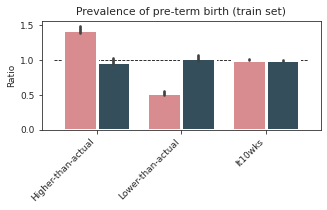

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
sns.barplot(x='Error group', y='Ratio', hue='dist', data=dt, palette=dist_cmap, ax=ax, linewidth=3)
ax.plot([*ax.get_xlim()], [1.0, 1.0], 'k--', linewidth=0.8, zorder=0)
ax.legend().set_visible(False)
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Prevalence of pre-term birth (train set)')

In [71]:
# g = sns.FacetGrid(dt, row='split', aspect=2)
# g.map_dataframe(sns.barplot, x='Error group', y='Ratio', hue='dist', palette=dist_cmap, dodge=True)
# for ax in g.axes.flat:
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

In [72]:
savefigs = True

In [73]:
a = res['ptb_37wks']['Higher-than-actual']
b = res['ptb_37wks']['lt10wks']
ttest_ind(a, b, equal_var=False)

Ttest_indResult(statistic=16.52273912356326, pvalue=1.581438102433665e-54)

In [74]:
list(dist_cmap.values())*3

['#2F5061', '#E57F84', '#2F5061', '#E57F84', '#2F5061', '#E57F84']

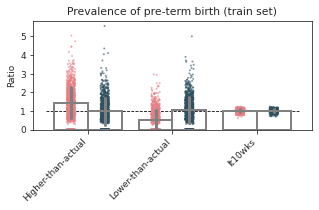

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
sns.stripplot(x='Error group', y='Ratio', 
              hue='dist', data=dt, 
              palette=dist_cmap, ax=ax, linewidth=0, 
              dodge=True, zorder=1, s=2, 
              alpha=0.6, rasterized=True)
sns.barplot(x='Error group', y='Ratio', hue='dist', data=dt, palette=dist_cmap, 
            ax=ax, zorder=2, facecolor='none', edgecolor='gray', linewidth=2, ci='sd', errwidth=3, errcolor='gray')
#             boxprops={'facecolor':'none','edgecolor':'k'})
ax.plot([*ax.get_xlim()], [1.0, 1.0], 'k--', linewidth=0.8, zorder=0)
ax.legend().set_visible(False)
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Prevalence of pre-term birth (train set)')
if savefigs:
    fig.savefig(os.path.join(pfp, 'boxplot_ratioVerrgrp_permtest_train_v72.pdf'), bbox_inches='tight', dpi=600)

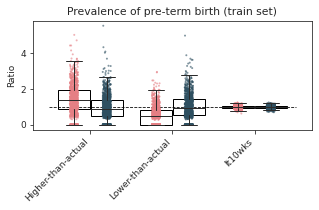

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
sns.stripplot(x='Error group', y='Ratio', 
              hue='dist', data=dt, 
              palette=dist_cmap, ax=ax, linewidth=0, 
              dodge=True, zorder=1, s=2, 
              alpha=0.6, rasterized=True)
sns.boxplot(x='Error group', y='Ratio', hue='dist', data=dt, palette=dist_cmap, ax=ax, linewidth=1, zorder=2, 
            boxprops={'facecolor':'none','edgecolor':'k'}, showfliers=False)
ax.plot([*ax.get_xlim()], [1.0, 1.0], 'k--', linewidth=0.8, zorder=0)
ax.legend().set_visible(False)
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Prevalence of pre-term birth (train set)')
if savefigs:
    fig.savefig(os.path.join(pfp, 'boxplot_ratioVerrgrp_permtest_train_v72.pdf'), bbox_inches='tight', dpi=600)

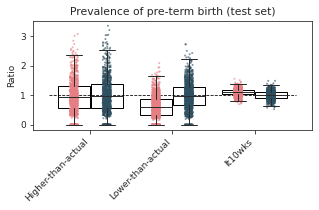

In [78]:
# bar plot from this
dt = pd.DataFrame()
for k in res_tst.keys():
    dtt = pd.DataFrame()
    for kk, vv in res_tst[k].items():
        dtt[kk] = vv
    dtt['var'] = k if 'null' not in k else k.split('_null')[0]
    if 'null' in k:
        dtt['dist'] = 'Null'
    else:
        dtt['dist'] = 'Obs'
    dt = dt.append(dtt)
    del dtt
dt = dt.melt(id_vars=['var', 'dist'], value_name='Ratio', var_name='Error group')

fig, ax = plt.subplots(1, 1, figsize=(5, 2))
sns.stripplot(x='Error group', y='Ratio', 
              hue='dist', data=dt, 
              palette=dist_cmap, ax=ax, linewidth=0, 
              dodge=True, zorder=1, s=2, 
              alpha=0.6, rasterized=True)
sns.boxplot(x='Error group', y='Ratio', hue='dist', data=dt, palette=dist_cmap, ax=ax, linewidth=1, zorder=2, 
            boxprops={'facecolor':'none','edgecolor':'k'}, showfliers=False)
ax.plot([*ax.get_xlim()], [1.0, 1.0], 'k--', linewidth=0.8, zorder=0)
ax.legend().set_visible(False)
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Prevalence of pre-term birth (test set)')
if savefigs:
    fig.savefig(os.path.join(pfp, 'boxplot_ratioVerrgrp_permtest_test_v72.pdf'), bbox_inches='tight', dpi=600)

In [79]:
res['ptb_37wks'].keys()

dict_keys(['Higher-than-actual', 'Lower-than-actual', 'lt10wks'])

In [80]:
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

In [81]:
a = dt.loc[(dt['dist']=='Obs') & (dt['Error group']=='lt10wks'), 'Ratio']
b = dt.loc[(dt['dist']=='Null') & (dt['Error group']=='lt10wks'), 'Ratio']
mannwhitneyu(a, b)

MannwhitneyuResult(statistic=300166.5, pvalue=2.5529829599795817e-54)

In [82]:
a = dt.loc[(dt['dist']=='Obs') & (dt['Error group']=='Lower-than-actual'), 'Ratio']
b = dt.loc[(dt['dist']=='Null') & (dt['Error group']=='Lower-than-actual'), 'Ratio']
mannwhitneyu(a, b)

MannwhitneyuResult(statistic=270247.5, pvalue=3.843378940493446e-71)

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


MannwhitneyuResult(statistic=277561.0, pvalue=1.0145652371837597e-67)
log2 FC: -0.976696256585193


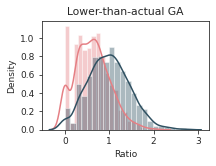

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
sns.distplot(dt.loc[(dt['dist']=='Obs') & (dt['Error group']=='Lower-than-actual'), 'Ratio'], color=dist_cmap['Obs'], ax=ax)
sns.distplot(dt.loc[(dt['dist']=='Null') & (dt['Error group']=='Lower-than-actual'), 'Ratio'], color=dist_cmap['Null'], ax=ax)
ax.set_title('Lower-than-actual GA')
a = res['ptb_37wks']['Lower-than-actual']
b = res['ptb_37wks_null']['Lower-than-actual']
print(mannwhitneyu(a, b))
print('log2 FC:', np.log2(np.mean(a)) - np.log2(np.mean(b)))
if savefigs:
    fig.savefig(os.path.join(pfp, 'distplot_lowerthanactual_obsVnull_v72.pdf'), bbox_inches='tight')

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


MannwhitneyuResult(statistic=331512.5, pvalue=2.8213752022824084e-39)
log2 FC: 0.5539556135696492


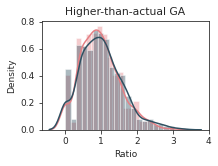

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
sns.distplot(dt.loc[(dt['dist']=='Obs') & (dt['Error group']=='Higher-than-actual'), 'Ratio'], color=dist_cmap['Obs'], ax=ax)
sns.distplot(dt.loc[(dt['dist']=='Null') & (dt['Error group']=='Higher-than-actual'), 'Ratio'], color=dist_cmap['Null'], ax=ax)
ax.set_title('Higher-than-actual GA')
a = res['ptb_37wks']['Higher-than-actual']
b = res['ptb_37wks_null']['Higher-than-actual']
print(mannwhitneyu(a, b))
print('log2 FC:', np.log2(np.mean(a)) - np.log2(np.mean(b)))
if savefigs:
    fig.savefig(os.path.join(pfp, 'distplot_Higherthanactual_obsVnull_v72.pdf'), bbox_inches='tight')


### (3) Is the difference statistically significant? 
- permutation test 

In [662]:
# shown above

### (4) what other interesting differences are there and how can we automate this process into a pipeline for risk assessment?

In [85]:
# plot all significant and simulate them, show with barplots

# order by 
dt = pd.Series(md_node_annotation).reset_index().rename(columns={'index':'var', 0:'cat'})
dt['cat'].value_counts()
dt = dt.merge(pd.DataFrame(pd.DataFrame(moi).T.rename(columns={k:v for k,v in zip(list(range(3)), ['-log10P', 'AU-PRC', 'AU-PRC (%-diff)'])})), 
         left_on='var', right_index=True, how='left')
dtt = pd.DataFrame(columns=dt.columns)
for cat in dt.value_counts('cat').index:
    dtt = dtt.append(dt.loc[dt['cat']==cat, :].sort_values(by='-log10P', ascending=False), ignore_index=True)
dt = dtt 
del dtt

In [86]:
sig_voi_cat = {}
sig_voi_cont = {}
for i in dt.index:
    if dt.loc[i, '-log10P'] >= -1*np.log10(0.01):#p_threshold:
        if mdpred_voi[dt.loc[i, 'var']] == 'continuous':
            sig_voi_cont[dt.loc[i, 'var']] = mdpred_voi[dt.loc[i, 'var']]
        else:
            sig_voi_cat[dt.loc[i, 'var']] = mdpred_voi[dt.loc[i, 'var']]
del sig_voi_cat['ptb_37wks']

In [87]:
res_cont = md_grpdiff_perm_test(md.loc[md['split']=='train'], voi=sig_voi_cont, value=max_categorical_obsVexp_ratio, verbose=True)

through n=1 trials and i=1 var of 5 in 0-s
through n=101 trials and i=1 var of 5 in 1-s
through n=201 trials and i=1 var of 5 in 2-s
through n=301 trials and i=1 var of 5 in 3-s
through n=401 trials and i=1 var of 5 in 4-s
through n=501 trials and i=1 var of 5 in 5-s
through n=601 trials and i=1 var of 5 in 6-s
through n=701 trials and i=1 var of 5 in 7-s
through n=801 trials and i=1 var of 5 in 8-s
through n=901 trials and i=1 var of 5 in 9-s
through n=1 trials and i=2 var of 5 in 10-s
through n=101 trials and i=2 var of 5 in 11-s
through n=201 trials and i=2 var of 5 in 12-s
through n=301 trials and i=2 var of 5 in 13-s
through n=401 trials and i=2 var of 5 in 14-s
through n=501 trials and i=2 var of 5 in 15-s
through n=601 trials and i=2 var of 5 in 16-s
through n=701 trials and i=2 var of 5 in 17-s
through n=801 trials and i=2 var of 5 in 18-s
through n=901 trials and i=2 var of 5 in 19-s
through n=1 trials and i=3 var of 5 in 20-s
through n=101 trials and i=3 var of 5 in 21-s
thro

In [88]:
res_cat = md_grpdiff_perm_test(md.loc[md['split']=='train'], voi=sig_voi_cat, value=max_categorical_obsVexp_ratio, verbose=True)

through n=1 trials and i=1 var of 19 in 0-s
through n=101 trials and i=1 var of 19 in 1-s
through n=201 trials and i=1 var of 19 in 2-s
through n=301 trials and i=1 var of 19 in 3-s
through n=401 trials and i=1 var of 19 in 4-s
through n=501 trials and i=1 var of 19 in 5-s
through n=601 trials and i=1 var of 19 in 6-s
through n=701 trials and i=1 var of 19 in 7-s
through n=801 trials and i=1 var of 19 in 8-s
through n=901 trials and i=1 var of 19 in 9-s
through n=1 trials and i=2 var of 19 in 10-s
through n=101 trials and i=2 var of 19 in 11-s
through n=201 trials and i=2 var of 19 in 12-s
through n=301 trials and i=2 var of 19 in 13-s
through n=401 trials and i=2 var of 19 in 13-s
through n=501 trials and i=2 var of 19 in 14-s
through n=601 trials and i=2 var of 19 in 15-s
through n=701 trials and i=2 var of 19 in 16-s
through n=801 trials and i=2 var of 19 in 17-s
through n=901 trials and i=2 var of 19 in 18-s
through n=1 trials and i=3 var of 19 in 19-s
through n=101 trials and i=3 

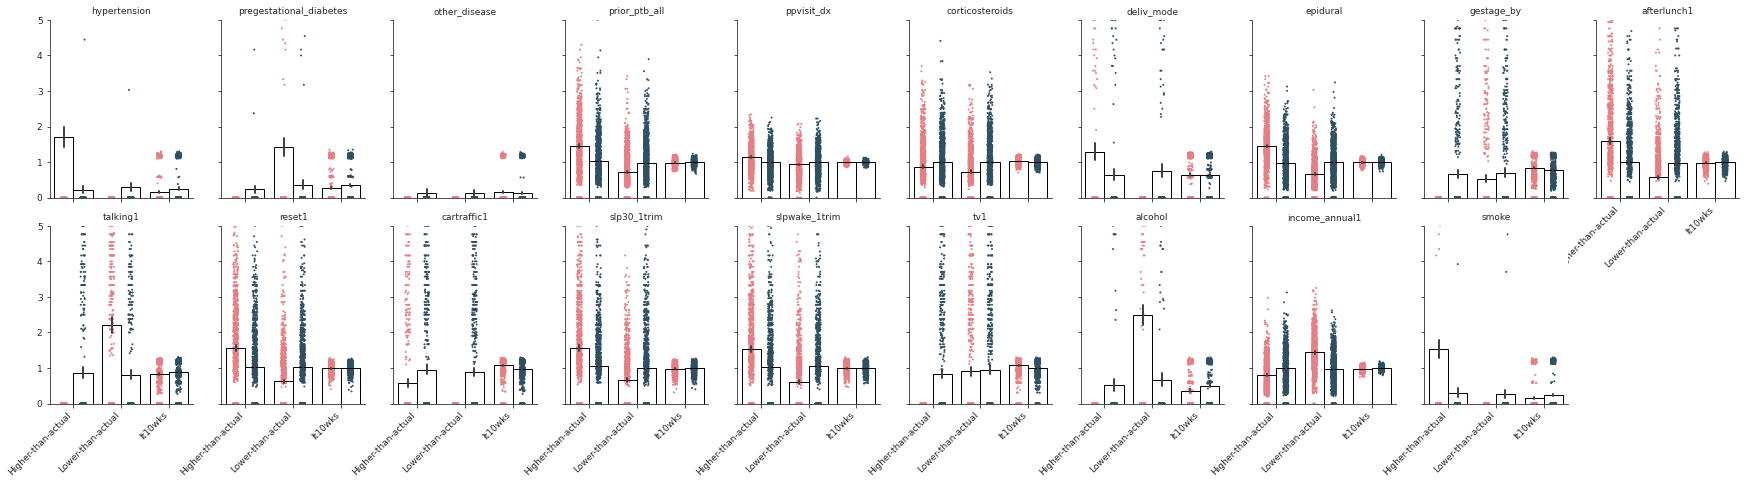

In [89]:
# bar plot from this
dt = pd.DataFrame()
for k in res_cat.keys():
    dtt = pd.DataFrame()
    for kk, vv in res_cat[k].items():
        dtt[kk] = vv
    dtt['var'] = k if 'null' not in k else k.split('_null')[0]
    if 'null' in k:
        dtt['dist'] = 'Null'
    else:
        dtt['dist'] = 'Obs'
    dt = dt.append(dtt)
    del dtt
dt = dt.melt(id_vars=['var', 'dist'], value_name='Ratio', var_name='Error group')

g = sns.FacetGrid(dt, col='var', aspect=0.8, col_wrap=10)
g.map_dataframe(sns.stripplot, x='Error group', y='Ratio', hue='dist', palette=dist_cmap, dodge=True, rasterized=True, zorder=0, s=2)
# g.map_dataframe(sns.boxplot, x='Error group', y='Ratio', hue='dist', palette=dist_cmap, dodge=True, rasterized=True, boxprops={'facecolor':'none', 'edgecolor':'k'})
g.map_dataframe(sns.barplot, x='Error group', y='Ratio', hue='dist', palette=dist_cmap, dodge=True, errwidth=2, zorder=1, facecolor='none', edgecolor='k')
g.set_titles('{col_name}')
g.set(ylim=(0, 5))
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
g.savefig(os.path.join(pfp, 'barplots_sigvar_cat_permtests_v72.pdf'), bbox_inches='tight')

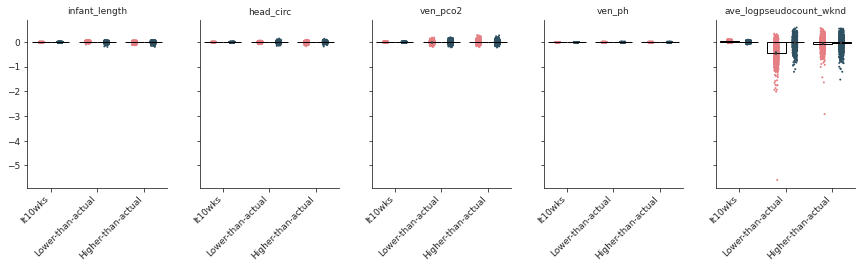

In [90]:
# bar plot from this
dt = pd.DataFrame()
for k in res_cont.keys():
    dtt = pd.DataFrame()
    for kk, vv in res_cont[k].items():
        dtt[kk] = vv
    dtt['var'] = k if 'null' not in k else k.split('_null')[0]
    if 'null' in k:
        dtt['dist'] = 'Null'
    else:
        dtt['dist'] = 'Obs'
    dt = dt.append(dtt)
    del dtt
dt = dt.melt(id_vars=['var', 'dist'], value_name='Ratio', var_name='Error group')

g = sns.FacetGrid(dt, col='var', aspect=0.8, col_wrap=10)
g.map_dataframe(sns.stripplot, x='Error group', y='Ratio', hue='dist', palette=dist_cmap, dodge=True, rasterized=True, zorder=0, s=2)
g.map_dataframe(sns.barplot, x='Error group', y='Ratio', hue='dist', palette=dist_cmap, dodge=True, errwidth=2, zorder=1, facecolor='none', edgecolor='k')
g.set_titles('{col_name}')
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
g.savefig(os.path.join(pfp, 'barplots_sigvar_cont_permtests_v72.pdf'), bbox_inches='tight')

# extract pvals

For writing, need more pvals... extract quickly w/minimal regeneration

In [93]:
pfp = '/home/ngrav/project/wearables/results/'
savefigs = True

In [94]:
# load md info
from wearables.scripts.md_specification import mdpred_voi
from wearables.scripts.aesthetics import md_node_annotation

# filepaths to bst or pre-processed md with calculated metrics 
pp_md_fp = os.path.join(pfp, 'md_220912.csv')

# load up to date md
md = pd.read_csv(pp_md_fp, index_col=0)
md['error'] = md['yhat'] - md['y']

threshold = 10
md['Error group'] = 'lt{}wks'.format(threshold)
md.loc[(md['error'] >= threshold), 'Error group'] = 'Higher-than-actual'
md.loc[(md['error'] <= -threshold), 'Error group'] = 'Lower-than-actual'


In [95]:
def range_scale(x, min_target=100, max_target=300):
    return ((x - np.min(x)) / (np.max(x) - np.min(x)))*(max_target - min_target) + min_target

In [96]:
md.head()

,record_id,age_enroll,marital,gestage_by,insur,ethnicity,race,bmi_1vis,prior_ptb_all,fullterm_births,...,KPAS,EpworthSS,Edinburgh,Pre-term birth,id,split,y,yhat,error,Error group
unique_id,,,,,,,,,,,,,,,,,,,,,
2180_12,2180,34.0,1.0,1.0,3.0,0.0,0.0,31.732640,0.0,0.0,...,9.053680,5.0,6.0,False,2180_12,test,12.0,15.189330,3.189330,lt10wks
2148_11,2148,34.0,1.0,2.0,3.0,0.0,0.0,22.406605,0.0,1.0,...,10.266234,9.0,7.0,False,2148_11,train,11.0,19.224419,8.224419,lt10wks
1062_8,1062,31.0,0.0,1.0,5.0,0.0,1.0,40.106270,0.0,0.0,...,9.493074,3.0,5.0,False,1062_8,train,8.0,15.505736,7.505736,lt10wks
1306_7,1306,25.0,0.0,3.0,5.0,0.0,1.0,24.555670,0.0,0.0,...,8.889610,9.0,9.0,False,1306_7,train,7.0,17.990391,10.990391,Higher-than-actual
2003_7,2003,38.0,1.0,1.0,1.0,0.0,1.0,37.804455,0.0,0.0,...,8.984632,8.0,3.0,False,2003_7,train,7.0,19.551502,12.551502,Higher-than-actual


In [97]:
# regenerate 
# plot all significant and simulate them, show with barplots

# order by 
dt = pd.Series(md_node_annotation).reset_index().rename(columns={'index':'var', 0:'cat'})
dt['cat'].value_counts()
dt = dt.merge(pd.DataFrame(pd.DataFrame(moi).T.rename(columns={k:v for k,v in zip(list(range(3)), ['-log10P', 'AU-PRC', 'AU-PRC (%-diff)'])})), 
         left_on='var', right_index=True, how='left')
dtt = pd.DataFrame(columns=dt.columns)
for cat in dt.value_counts('cat').index:
    dtt = dtt.append(dt.loc[dt['cat']==cat, :].sort_values(by='-log10P', ascending=False), ignore_index=True)
dt = dtt 
del dtt

sig_voi_cat = {}
sig_voi_cont = {}
for i in dt.index:
    if dt.loc[i, '-log10P'] >= -1*np.log10(0.01):#p_threshold:
        if mdpred_voi[dt.loc[i, 'var']] == 'continuous':
            sig_voi_cont[dt.loc[i, 'var']] = mdpred_voi[dt.loc[i, 'var']]
        else:
            sig_voi_cat[dt.loc[i, 'var']] = mdpred_voi[dt.loc[i, 'var']]
del sig_voi_cat['ptb_37wks']

max_categorical_obsVexp_ratio = get_max_value(md, mdpred_voi) # from wearables.scripts.aesthetics import max_categorical_obsVexp_ratio


res_cat = md_grpdiff_perm_test(md.loc[md['split']=='train'], voi=sig_voi_cat, value=max_categorical_obsVexp_ratio, verbose=True)

/tmp/ipykernel_3378071/2724408599.py:59: RuntimeWarning: invalid value encountered in log2
  'log2_grpVall' : {str(gg):np.log2(df.loc[df[groupby]==gg, g].mean()) - np.log2(df[g].mean()) for gg in df[groupby].unique()},


through n=1 trials and i=1 var of 19 in 0-s
through n=101 trials and i=1 var of 19 in 1-s
through n=201 trials and i=1 var of 19 in 2-s
through n=301 trials and i=1 var of 19 in 3-s
through n=401 trials and i=1 var of 19 in 4-s
through n=501 trials and i=1 var of 19 in 5-s
through n=601 trials and i=1 var of 19 in 6-s
through n=701 trials and i=1 var of 19 in 7-s
through n=801 trials and i=1 var of 19 in 8-s
through n=901 trials and i=1 var of 19 in 9-s
through n=1 trials and i=2 var of 19 in 10-s
through n=101 trials and i=2 var of 19 in 11-s
through n=201 trials and i=2 var of 19 in 12-s
through n=301 trials and i=2 var of 19 in 13-s
through n=401 trials and i=2 var of 19 in 14-s
through n=501 trials and i=2 var of 19 in 14-s
through n=601 trials and i=2 var of 19 in 15-s
through n=701 trials and i=2 var of 19 in 16-s
through n=801 trials and i=2 var of 19 in 17-s
through n=901 trials and i=2 var of 19 in 18-s
through n=1 trials and i=3 var of 19 in 19-s
through n=101 trials and i=3 

In [98]:
max_categorical_obsVexp_ratio

{'marital': 1.0,
 'gestage_by': 4.0,
 'insur': 4.0,
 'ethnicity': 1.0,
 'race': 0.0,
 'prior_ptb_all': 1.0,
 'fullterm_births': 0.0,
 'surghx_none': 0.0,
 'alcohol': 2.0,
 'smoke': 2.0,
 'drugs': 2.0,
 'hypertension': 2.0,
 'pregestational_diabetes': 2.0,
 'asthma_yes___1': 1.0,
 'asthma_yes___2': 1.0,
 'asthma_yes___3': 1.0,
 'asthma_yes___4': 1.0,
 'asthma_yes___5': 1.0,
 'asthma_yes___7': 1.0,
 'asthma_yes___8': 1.0,
 'asthma_yes___10': 1.0,
 'asthma_yes___13': 1.0,
 'asthma_yes___18': 1.0,
 'asthma_yes___19': 1.0,
 'asthma_yes___20': 1.0,
 'other_disease': 2.0,
 'gestational_diabetes': 1.0,
 'ghtn': 1.0,
 'preeclampsia': 1.0,
 'rh': 1.0,
 'corticosteroids': 1.0,
 'abuse': 1.0,
 'assist_repro': 1.0,
 'gyn_infection': 1.0,
 'ptb_37wks': 1.0,
 'anes_type': 6.0,
 'epidural': 0.0,
 'deliv_mode': 3.0,
 'death_baby': 1.0,
 'neonatal_complication': 1.0,
 'ervisit': 1.0,
 'ppvisit_dx': 1.0,
 'education': 0.0,
 'paidjob1': 0.0,
 'work_hrs1': 1.0,
 'income_annual1': 1.0,
 'income_support1': 0

In [99]:
from scipy.stats import kruskal, ttest_ind, mannwhitneyu

In [100]:
def p_encoder(p):
    if p > 0.05:
        label = '' # n.s.
    elif p <= 0.001:
        label = '***'
    elif p <= 0.05 and p > 0.01:
        label = '*'
    elif p <= 0.01 and p > 0.001:
        label = '**'
    else: 
        label = 'Unclassified'
    return label

In [101]:
## kruskala wallis per var and later bonferonni
print('Across group comparison and btw higher and normal and lower and normal pvals:')
n = len(sig_voi_cat.keys())
print('  n={} comparisons'.format(n))  
for k in sig_voi_cat.keys():
    stat, p = kruskal(*[res_cat[k][kk] for kk in res_cat[k].keys()])
    stat_n, p_n = mannwhitneyu(res_cat[k]['lt10wks'], res_cat[f"{k}_null"]['lt10wks'])
    stat_hvn, p_hvn = mannwhitneyu(res_cat[k]['Higher-than-actual'], res_cat[f"{k}_null"]['Higher-than-actual'])
    stat_lvn, p_lvn = mannwhitneyu(res_cat[k]['Lower-than-actual'], res_cat[f"{k}_null"]['Lower-than-actual'])
    
    p = p*n
    p_n = p_n*n
    p_hvn = p_hvn*n
    p_lvn = p_lvn*n
    
    print(f"{k}\tGroup P: {p:.2e}{p_encoder(p)}\tp_norm: {p_n:.2e}{p_encoder(p_n)}\tp_high: {p_hvn:.2e}{p_encoder(p_hvn)}\tp_low: {p_lvn:.2e}{p_encoder(p_lvn)}")

Across group comparison and btw higher and normal and lower and normal pvals:
  n=19 comparisons
hypertension	Group P: 1.18e-31***	p_norm: 3.99e-08***	p_high: 1.25e-20***	p_low: 3.31e-04***
pregestational_diabetes	Group P: 3.98e-58***	p_norm: 1.61e-02*	p_high: 4.67e-09***	p_low: 2.46e-15***
other_disease	Group P: 2.10e-58***	p_norm: 2.12e+00	p_high: 1.66e-03**	p_low: 4.38e-02*
prior_ptb_all	Group P: 5.22e-155***	p_norm: 8.84e-05***	p_high: 2.17e-44***	p_low: 4.29e-24***
ppvisit_dx	Group P: 2.47e-57***	p_norm: 1.62e-04***	p_high: 7.38e-20***	p_low: 5.71e-05***
corticosteroids	Group P: 2.81e-56***	p_norm: 9.61e-19***	p_high: 1.18e-01	p_low: 4.81e-20***
deliv_mode	Group P: 8.09e-185***	p_norm: 9.38e+00	p_high: 2.74e-06***	p_low: 8.49e-21***
epidural	Group P: 1.14e-261***	p_norm: 7.66e-04***	p_high: 1.74e-68***	p_low: 6.13e-47***
gestage_by	Group P: 0.00e+00***	p_norm: 8.44e-06***	p_high: 1.54e-43***	p_low: 5.15e-03**
afterlunch1	Group P: 1.89e-102***	p_norm: 5.30e-01	p_high: 2.68e-21***	p

/tmp/ipykernel_3378071/2537414455.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=90)
/tmp/ipykernel_3378071/2537414455.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=90)
/tmp/ipykernel_3378071/2537414455.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=90)
/tmp/ipykernel_3378071/2537414455.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=90)
/tmp/ipykernel_3378071/2537414455.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=90)
/tmp/ipykernel_3378071/2537414455.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=90)
/tmp/ipykernel_3378071/2537414455.py:30: UserWarning: FixedFormatter should only b

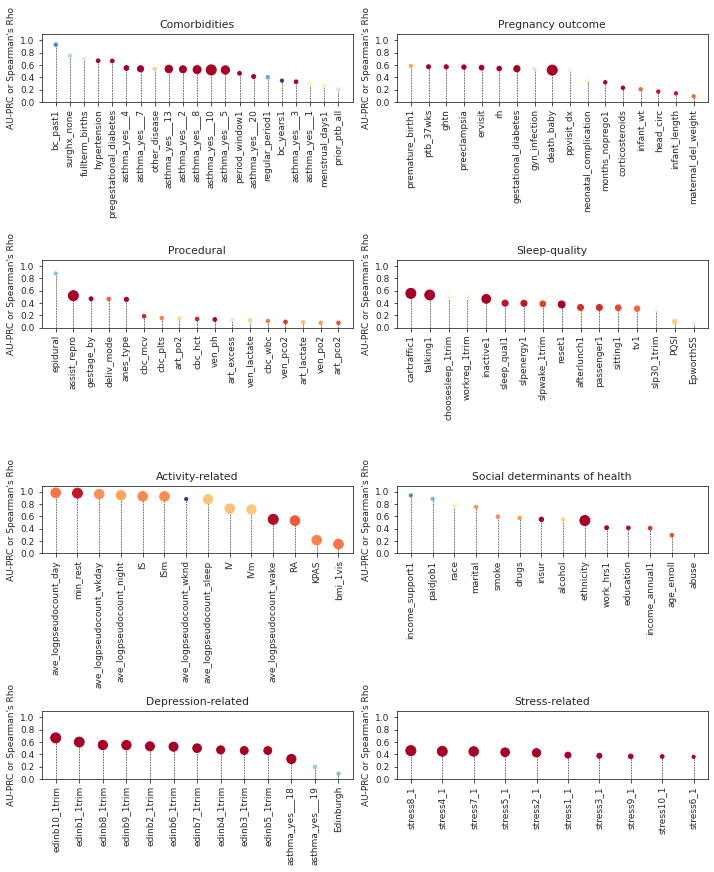

In [102]:
# regen plot
resknn10 = loadpkl(os.path.join(pfp, 'md_predictability_knn_10wk.pkl'))
moi = wearutils.metric_list(resknn10, mdpred_voi, top1=True) #, clf_metric='balanced_acc')

dt = pd.Series(md_node_annotation).reset_index().rename(columns={'index':'var', 0:'cat'})
dt['cat'].value_counts()
dt = dt.merge(pd.DataFrame(pd.DataFrame(moi).T.rename(columns={k:v for k,v in zip(list(range(3)), ['-log10P', 'AU-PRC', 'AU-PRC (%-diff)'])})), 
         left_on='var', right_index=True, how='left')
# actually, not the right name in the columns
dt = dt.rename(columns={'AU-PRC': 'AU-PRC or Rho', 'AU-PRC (%-diff)': '%-diff or MAPE'})

# re-rank
dtt = pd.DataFrame(columns=dt.columns)
for cat in dt.value_counts('cat').index:
    dtt = dtt.append(dt.loc[dt['cat']==cat, :].sort_values(by='AU-PRC or Rho', ascending=False), ignore_index=True)
dt = dtt 
del dtt
dtt = dt.loc[dt['cat']==cat, :]
x, y, c = dtt['var'], dtt['AU-PRC or Rho'], dtt['%-diff or MAPE']

# seperate per grp 
fig = plt.figure(figsize=(10, 12))
for i, cat in enumerate(dt['cat'].unique()):
    ax = fig.add_subplot(4, 2, i+1)
    dtt = dt.loc[dt['cat']==cat, :]
    x, y, c = dtt['var'], dtt['AU-PRC or Rho'], dtt['%-diff or MAPE']
    im = ax.scatter(x, y, c=c, s=range_scale(c, min_target=10, max_target=100), vmin=0, vmax=1, cmap='RdYlBu_r')
    for ii in range(len(x)):
        ax.plot([x.iloc[ii], x.iloc[ii]], [0, y.iloc[ii]], 'k--', linewidth=0.5, zorder=0)
    ax.set_xticklabels(x, rotation=90)
#     fig.colorbar(im, ax=ax, label='%-diff or MAPE')
    ax.set_ylabel("AU-PRC or Spearman's Rho")
    ax.set_ylim([0, 1.1])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_title(cat)
fig.tight_layout()
if savefigs:
    fig.savefig(os.path.join(pfp, 'barplot_AUPRC-RhoVvars_by_cat_2_v72.pdf'), bbox_inches='tight')